<a href="https://colab.research.google.com/github/macdinh99/LSTM_GRU_Hydrid/blob/main/Volatility_BTC_MV_LSTM_GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tổng quan**

Trong tương lai, dự báo Biến động thực tế trung bình hàng ngày (RV) của BTC-USD trong 7 ngày tiếp theo sử dụng 2 phương pháp khác nhau - phương pháp kinh tế lượng truyền thống cho dự báo biến động của chuỗi thời gian tài chính GARCH và Mạng nơ-ron LSTM tiên tiến.

In [ ]:
#Cài đặt gói Arch/Garch
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 10.3 MB/s eta 0:00:00


In [ ]:
#Cài đặt gói Yahoo, lấy dữ liệu tự động
!pip3 install yfinance

**Vấn đề kinh doanh**

Biến động cố gắng đo lường mức độ biến đổi giá mà một công cụ tài chính trải qua trong một khoảng thời gian nhất định. Mức độ biến đổi càng đậm đào động giá trong công cụ đó, thì mức độ biến đổi càng cao, và ngược lại.

Biến động thường được chấp nhận là chỉ số tốt nhất của rủi ro thị trường và việc dự báo biến động được sử dụng trong nhiều ứng dụng khác nhau trong ngành công nghiệp. Các mô hình Dự báo Biến động thực tế thường được sử dụng trong quản lý rủi ro, tạo thị trường, tối ưu hóa danh mục và giao dịch quyền chọn. Cụ thể, theo Sinclair (2020), nhiều chiến lược giao dịch phát triển xung quanh việc xác định các tình huống mà không phù hợp về biến động xảy ra:

# 𝑃/𝐿=𝑉𝑒𝑔𝑎|𝜎𝑖𝑚𝑝𝑙𝑖𝑒𝑑−𝜎𝑟𝑒𝑎𝑙𝑖𝑧𝑒𝑑|

trong đó Vega là đo lường sự nhạy cảm của giá quyền chọn đối với các thay đổi về biến động của tài sản cơ sở, và 𝜎 là biến động. Vì Biến động Hàm Ý (IV) có thể được tạo ra từ Giá Quyền chọn sử dụng các mô hình như Mô hình Black Scholes, việc dự báo Biến động Thực tế sẽ mang lại cho chúng ta yếu tố quyết định của phần thứ hai của phương trình.

Mặc dù việc dự báo và mô hình hóa biến động đã là trọng tâm của nhiều nghiên cứu thực nghiệm và điều tra lý thuyết trong học thuật, việc dự báo biến động một cách chính xác vẫn là một thách thức quan trọng đối với các nhà nghiên cứu. Hơn nữa, vì giao dịch quyền chọn tiền điện tử là một lĩnh vực mới, chưa có nhiều nghiên cứu được tiến hành về dự báo biến động Bitcoin này. Ngoài ra, tiền điện tử mang theo một số đặc điểm riêng biệt khác biệt so với cổ phiếu và hàng hóa truyền thống được quy định, điều này cũng cần được tính đến.

**Tập dữ liệu**
Tập dữ liệu lịch sử về giá mở/cửa/cao/thấp của Bitcoin được thu thập bằng cách sử dụng API Yahoo Finance yfinance. API này miễn phí, rất dễ cài đặt, nhưng vẫn chứa một loạt dữ liệu và ưu đãi rộng lớn.

Tôi sẽ tải xuống giá BTC-USD bằng cách sử dụng ký hiệu BTC-USD với khoảng thời gian 1 ngày. Yahoo không thêm Bitcoin cho đến năm 2014; do đó, mặc dù nó được giao dịch lần đầu vào năm 2009, yfinance chỉ chứa dữ liệu từ tháng 9 năm 2014 đến nay (tháng 9 năm 2023). Do đó, tôi sẽ làm việc với khoảng 2.500 điểm dữ liệu bao gồm khoảng 7 năm giao dịch.

In [ ]:
#Khai báo thư viện

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR MODEL PERFORMANCE DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# PRE-SET PATH TO images FOLDER TO SAVE PLOTS LATER
directory_to_img = os.path.join('/content/drive/MyDrive/garch_lstm')

In [ ]:
# SET SEED FOR REPRODUCIBILITY
seed = 2023

In [ ]:
# SELECT START AND END DATE
start = datetime(2015, 1, 1)
end = datetime(2023, 10, 15)

tckr = 'BTC-USD'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start,
                    end=end,
                    interval="1d")

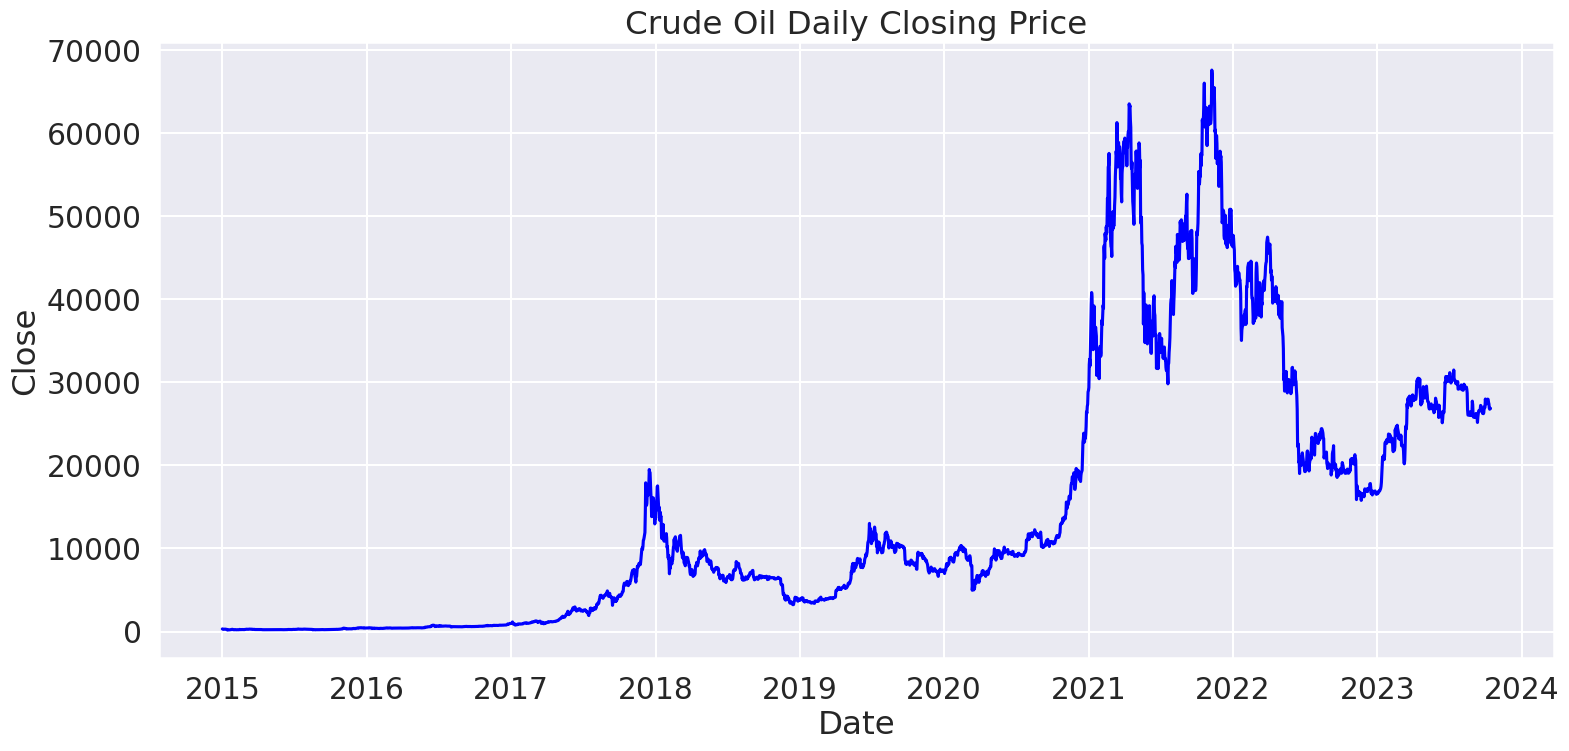

In [ ]:
# CHANGE CONTEXT TO poster TO INCREASE FONT SIZES
sns.set_context("talk", font_scale=1.3)

# PLOT OUT BTC-USE'S CLOSING PRICES SINCE 2014
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('Crude Oil Daily Closing Price')

In [ ]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-01 00:00:00+00:00,320.434998,320.434998,314.002991,314.248993,8036550,0.0,0.0
2015-01-02 00:00:00+00:00,314.079010,315.838989,313.565002,315.032013,7860650,0.0,0.0
2015-01-03 00:00:00+00:00,314.846008,315.149994,281.082001,281.082001,33054400,0.0,0.0
2015-01-04 00:00:00+00:00,281.145996,287.230011,257.612000,264.195007,55629100,0.0,0.0
2015-01-05 00:00:00+00:00,265.084015,278.341003,265.084015,274.473999,43962800,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-10 00:00:00+00:00,27589.201172,27715.847656,27301.654297,27391.019531,9973350678,0.0,0.0
2023-10-11 00:00:00+00:00,27392.076172,27474.115234,26561.099609,26873.320312,13648094333,0.0,0.0
2023-10-12 00:00:00+00:00,26873.292969,26921.439453,26558.320312,26756.798828,9392909295,0.0,0.0


**Các loại Biến động và Cách đo lường chúng**

Nguồn: https://www.investopedia.com/terms/v/vix.asp

Biến động cố gắng đo lường mức độ biến đổi giá mà một công cụ tài chính trải qua trong một khoảng thời gian nhất định. Mức độ biến đổi càng đậm đào động giá trong công cụ đó, thì mức độ biến đổi càng cao, và ngược lại.

"Biến động không đo lường hướng của các thay đổi giá, mà chỉ đo lường mức độ phân tán của chúng. Điều này bởi vì khi tính độ lệch chuẩn (hoặc phương sai), tất cả sự khác biệt đều được bình phương, để những khác biệt âm và dương được kết hợp thành một lượng. Hai công cụ có biến động khác nhau có thể có cùng lợi nhuận kỳ vọng, nhưng công cụ có biến động cao hơn sẽ có biến động lớn hơn trong giá trị trong một khoảng thời gian nhất định." (Nguồn: Wikipedia)

Biến động có thể được chia thành hai loại: biến động lịch sử hoặc biến động hàm ý; cả hai thường được thể hiện dưới dạng phần trăm.

Biến động lịch sử (HV) hoặc Biến động thực tế là biến động thực sự được thể hiện bởi tài sản cơ sở trong một khoảng thời gian như tháng hoặc năm trước. Biến động thực tế thường được tính toán như độ lệch chuẩn của lợi nhuận giá, tức là sự thay đổi về giá theo tỷ lệ phần trăm so với giá của ngày trước đó.

Trái lại, biến động hàm ý (IV) là mức độ biến động của tài sản cơ sở được ngụ ý từ giá quyền chọn hiện tại.

In [ ]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

Vì mục đích thực tế, thường thì việc sử dụng tỷ lệ lợi nhuận logarithmic (log returns) là ưu tiên hơn, đặc biệt trong mô hình toán học, bởi vì nó giúp loại bỏ các tính chất phiễn độ của dữ liệu chuỗi thời gian và làm cho nó ổn định hơn:

**CÔNG THỨC TỶ LỆ LỢI NHUẬN LOGARITHMIC:**

𝑟𝑡,𝑡+𝑖=𝑙𝑜𝑔(𝑃𝑡+𝑖/𝑃𝑡)

Còn một lợi ích khác của tỷ lệ lợi nhuận logarithmic, đó là chúng cộng dồn theo thời gian: 𝑟𝑡1, 𝑡2+𝑟𝑡2, 𝑡3=𝑟𝑡1, 𝑡3

In [ ]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns
Date,,,,,,,,,
2015-01-01 00:00:00+00:00,320.434998,320.434998,314.002991,314.248993,8036550,0.0,0.0,NaN,NaN
2015-01-02 00:00:00+00:00,314.079010,315.838989,313.565002,315.032013,7860650,0.0,0.0,0.249172,0.002489
2015-01-03 00:00:00+00:00,314.846008,315.149994,281.082001,281.082001,33054400,0.0,0.0,-10.776686,-0.114028
2015-01-04 00:00:00+00:00,281.145996,287.230011,257.612000,264.195007,55629100,0.0,0.0,-6.007853,-0.061959
2015-01-05 00:00:00+00:00,265.084015,278.341003,265.084015,274.473999,43962800,0.0,0.0,3.890684,0.038169


**Cả tỷ lệ lợi nhuận và tỷ lệ lợi nhuận logarithmic đều thể hiện một số đặc điểm như sau:**

- Hơi lệch âm nhẹ
- Độ nhọn dương (leptokurtic) - đỉnh cao hơn và đuôi dày hơn so với phân phối chuẩn tiêu chuẩn

( Nguồn: https://www.investopedia.com/articles/investing/102715/computing-historical-volatility-excel.asp )

Độ lệch chuẩn sẽ khác nhau đối với tỷ lệ lợi nhuận logarithmic được tính trong các khoảng thời gian dài hoặc ngắn khác nhau. Đối với dự án cụ thể này, biến động cho một cửa sổ khoảng thời gian cố định cụ thể (INTERVAL_WINDOW) là độ lệch chuẩn của tỷ lệ lợi nhuận logarithmic, hoặc căn bậc hai của tổng các bình phương của tỷ lệ lợi nhuận logarithmic:

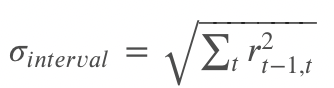

Sau đó, để điều chỉnh biến động hàng ngày bằng một tần suất cụ thể (hàng tuần, hàng tháng, hàng năm), chúng ta có thể nhân biến động hàng ngày với căn bậc hai của tần suất đó tính bằng ngày chia cho khoảng thời gian - 1 (INTERVAL_WINDOW - 1). Ví dụ:
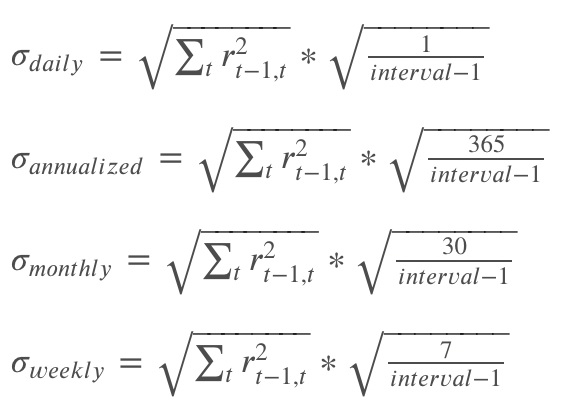

In [ ]:
# DROPPING THE 1ST ROW OF DATA
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

In [ ]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

**Lựa chọn Cửa Sổ Khoảng Thời Gian**

Đối với dự án cụ thể này, tôi sẽ sử dụng một cửa sổ khoảng thời gian là 30 ngày (tương đương với khoảng 1 tháng giao dịch cho tiền điện tử). Mục tiêu ở đây là dự báo biến động thực tế trung bình của 7 ngày tiếp theo sử dụng tất cả các điểm dữ liệu trước đó có sẵn với các mô hình GARCH (dự báo cửa sổ mở rộng), và sử dụng một số điểm dữ liệu quá khứ gần/nhị phân (n_past) với Mạng Nơ-ron (dự báo cửa sổ trượt).

In [ ]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

Lý do tôi chọn 30 ngày là vì 7 ngày dường như quá nhiễu để quan sát các mô hình ý nghĩa, trong khi các khoảng thời gian dài hơn thường làm giảm đi đáng kể độ biến động và có xu hướng quay trở lại giá trị trung bình.

Sử dụng cửa sổ khoảng thời gian là 30 ngày cũng giúp tránh tốn quá nhiều điểm dữ liệu ở đầu tập dữ liệu.

Các mô hình dự báo chuỗi thời gian là những mô hình có khả năng dự đoán các giá trị tương lai dựa trên các giá trị quan sát trước đó. Dữ liệu "tương lai" trong trường hợp này được thu được bằng cách dịch chuyển biến động hiện tại về phía sau bằng số lag n_future.

Ví dụ, so với thứ Hai của tuần trước, thứ Hai của tuần này được coi là "tương lai"; do đó, tôi chỉ cần dịch chuyển biến động của tuần này trở lại 7 ngày, và sử dụng nó làm đầu ra "tương lai" mong muốn cho tuần trước, sau đó tôi sẽ sử dụng nó để huấn luyện Mạng Nơ-ron và đánh giá hiệu suất của mô hình.

In [ ]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns,vol_current,vol_future
count,3208.000000,3208.000000,3208.000000,3208.000000,3.208000e+03,3208.0,3208.0,3208.000000,3208.000000,3179.000000,3172.000000
mean,14483.914028,14826.081942,14109.301964,14490.828247,1.700014e+10,0.0,0.0,0.209139,0.001387,0.034544,0.034450
std,16026.950953,16418.535950,15579.598732,16023.347711,1.934021e+10,0.0,0.0,3.734111,0.037655,0.016026,0.015919
min,176.897003,211.731003,171.509995,178.102997,7.860650e+06,0.0,0.0,-37.169539,-0.464730,0.007228,0.007228
25%,1132.057526,1173.004974,1110.959991,1141.170044,2.823775e+08,0.0,0.0,-1.248535,-0.012564,0.023548,0.023533
50%,8317.975586,8511.888672,8141.056641,8314.379395,1.213245e+10,0.0,0.0,0.135876,0.001358,0.032420,0.032383
75%,23043.578125,23433.773438,22666.192871,23088.511230,2.769496e+10,0.0,0.0,1.708676,0.016942,0.043525,0.043486
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0,25.247169,0.225119,0.103878,0.103878


In [ ]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,returns,log_returns,vol_current,vol_future
count,3208.000000,3208.000000,3208.000000,3208.000000,3.208000e+03,3208.000000,3208.000000,3179.000000,3172.000000
mean,14483.914028,14826.081942,14109.301964,14490.828247,1.700014e+10,0.209139,0.001387,0.034544,0.034450
std,16026.950953,16418.535950,15579.598732,16023.347711,1.934021e+10,3.734111,0.037655,0.016026,0.015919
min,176.897003,211.731003,171.509995,178.102997,7.860650e+06,-37.169539,-0.464730,0.007228,0.007228
25%,1132.057526,1173.004974,1110.959991,1141.170044,2.823775e+08,-1.248535,-0.012564,0.023548,0.023533
50%,8317.975586,8511.888672,8141.056641,8314.379395,1.213245e+10,0.135876,0.001358,0.032420,0.032383
75%,23043.578125,23433.773438,22666.192871,23088.511230,2.769496e+10,1.708676,0.016942,0.043525,0.043486
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,25.247169,0.225119,0.103878,0.103878


Vì tôi đang sử dụng một Cửa Sổ Khoảng Thời Gian (INTERVAL_WINDOW) là 30 và một đầu nhìn tương lai (n_future) là 7, nên biến động của 30 giá trị đầu tiên cũng như 7 giá trị cuối cùng trong bảng dữ liệu sẽ là NaN, và do đó cần phải loại bỏ chúng khỏi tập dữ liệu.

In [ ]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)


**Phân Tích Khám Phá Dữ Liệu**

Đầu tiên, tôi sẽ chỉ đơn giản là vẽ biểu đồ đầu ra mục tiêu mong muốn của tôi, tức là vol_future so với biến động hiện tại vol_current. Biểu đồ đầu tiên cho thấy tất cả các điểm dữ liệu mà tôi có sẵn trong vòng 7 năm, nhưng biểu đồ thứ hai chỉ đang thu nhỏ trong 365 ngày gần đây nhất.

Trong biểu đồ trên, đường màu xanh biểu thị giá trị mục tiêu tương lai mà tôi cuối cùng muốn khớp.

Và đường nét đứt màu xám biểu thị biến động hiện tại trong thời gian thực.

Đây là một hình ảnh hóa về cách biến động hiện tại được dịch chuyển về phía sau để trở thành các giá trị tương lai, mà tôi muốn cuối cùng đạt được.

**Biến Động Hằng Ngày Nhóm Theo Tháng**

In [ ]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2020-04-06 00:00:00+00:00    0.103878
2020-04-03 00:00:00+00:00    0.103330
2020-04-02 00:00:00+00:00    0.103319
2020-03-30 00:00:00+00:00    0.103302
2020-03-31 00:00:00+00:00    0.103300
2020-04-01 00:00:00+00:00    0.103203
2020-04-05 00:00:00+00:00    0.103192
2020-04-04 00:00:00+00:00    0.103175
2020-04-10 00:00:00+00:00    0.103052
2020-04-07 00:00:00+00:00    0.102421
2020-04-09 00:00:00+00:00    0.102414
2020-04-08 00:00:00+00:00    0.102411
2020-03-29 00:00:00+00:00    0.102179
2020-03-24 00:00:00+00:00    0.102140
2020-03-25 00:00:00+00:00    0.102018
2020-03-23 00:00:00+00:00    0.101864
2020-03-26 00:00:00+00:00    0.101844
2020-03-28 00:00:00+00:00    0.101738
2020-03-27 00:00:00+00:00    0.101523
2020-03-22 00:00:00+00:00    0.100300
2020-03-19 00:00:00+00:00    0.100166
2020-03-20 00:00:00+00:00    0.099710
2020-03-21 00:00:00+00:00    0.099709
2020-03-17 00:00:00+00:00    0.095724
2020-03-18 00:00:00+00:00    0.095614
2020-03-16 00:00:00+00:00    0.095421
2020-03

**Có thể quan sát được rằng:**

- Biến động thường đạt đến một số điểm cao trong các tháng Tháng Mười Hai/Tháng Một theo lịch sử.
- Tháng Ba và Tháng Tư có số lượng ngoại lệ lớn nhất.
- Trong khi tháng Tám và Tháng Chín (những tháng sắp tới trong dự báo thử nghiệm cuối cùng) theo lịch sử thường khá yên bình.

**Biến Động Hằng Ngày Nhóm Theo Năm**

In [ ]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).vol_current.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

**Các đồng tiền điện tử đã trải qua một số thay đổi cấu trúc lớn trong vài năm qua đã ảnh hưởng trực tiếp đến biến động, như:**


Lựa chọn Crypto trở nên có sẵn trên Deribit vào năm 2016.
Hợp đồng tương lai Bitcoin được mở rộng trên Sở giao dịch hàng hóa Chicago (CME) vào năm 2017.
Sau đó, Lựa chọn Bitcoin của CME vào năm 2020.
Những sự kiện này đã cho phép mọi người giao dịch biến động tiền điện tử một cách hiệu quả hơn, và do đó, dữ liệu trước năm 2016 có khả năng khác biệt về cấu trúc và có thể tuân thủ các mẫu khác so với dữ liệu sau năm 2016.

Chúng ta có thể thấy những sự kiện lớn này được phản ánh trong biểu đồ trên - đỉnh ghi nhận đầu tiên của Bitcoin vào năm 2017 (khoảng 19.800 USD vào cuối tháng 12). Và các điểm ngoại lệ vào năm 2020 tương ứng với sự tăng trưởng hơn 200% của nó trong năm 2020 (Bitcoin bắt đầu từ 7.200 USD vào đầu năm 2020). Nó đạt 20.000 USD trên hầu hết các sàn giao dịch vào ngày 15/12/2020, và sau đó tiếp tục đạt 30.000 USD chỉ sau 17 ngày, đó không phải là một thành tựu nhỏ. Để so sánh, chỉ mất Dow Jones gần 3 năm để thực hiện cùng một bước đi. Sau đó, vào ngày 07/01/2021, nó vượt qua mốc 40.000 USD. Vào thời điểm viết báo cáo này, BTC-USD được giao dịch ở mức cao 49.700 USD.

Có thể quan sát rằng biến động hàng ngày của năm 2021 nói chung cũng đã ở mức cao.

**Daily Volatility Distribution**

The distribution of daily realized volatility is lightly right skewed, with a small number of larger values spreaded thinly on the right.

A skewed right distribution would have smaller median compared to mean, and mode smaller than median (mode < median < mean).

**Returns/Log Returns Stationarity Checking**

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -57.717862933436194
p-value: 0.0
Critical Values:
1%: -3.4324
5%: -2.8625
10%: -2.5673


In [ ]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -57.61995237307905
p-value: 0.0
Critical Values:
1%: -3.4324
5%: -2.8625
10%: -2.5673


Sử dụng mức ý nghĩa alpha đáng kể là 0.05, giá trị p cho cả Tỷ Lệ Lợi Nhuận (Returns) và Tỷ Lệ Lợi Nhuận Logarithmic (Log Returns) đều nhỏ hơn đáng kể so với alpha, điều này có nghĩa là có đủ bằng chứng để bác bỏ giả thuyết H0.

--> Cả Tỷ Lệ Lợi Nhuận (Returns) và Tỷ Lệ Lợi Nhuận Logarithmic (Log Returns) đều không phụ thuộc vào thời gian/xu hướng.

# **Chia Dữ Liệu Ra Làm Ba Phần: Huấn Luyện - Xác Thực - Kiểm Tra**

Tổng cộng có 2500 điểm dữ liệu hữu ích trong tập dữ liệu này, bao gồm một khoảng thời gian gần 7 năm từ tháng 10 năm 2014 cho đến nay (cuối tháng 8 năm 2021). Do tiền điện tử không được giao dịch trên một sàn giao dịch được quy định, thị trường Bitcoin mở cửa 24/7, 1 năm bao gồm 365 ngày giao dịch thay vì 252 ngày một năm như với các cổ phiếu và hàng hóa khác.

*Tôi sẽ chia tập dữ liệu thành 3 phần như sau:*

- 30 điểm dữ liệu mới nhất sẽ được sử dụng cho Kiểm Tra Mô Hình Cuối Cùng - khoảng 1.2%
- 1 năm đầy đủ (365 ngày) cho Xác Thực và Điều Chỉnh Mô Hình trong quá trình huấn luyện - khoảng 14.7%
- Và phần còn lại cho Quá Trình Huấn Luyện - khoảng 84.1%

In [ ]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [ ]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2015-01-31 00:00:00+00:00 	to: 2022-09-07 00:00:00+00:00 	2777 days
VALIDATION 	From: 2022-09-08 00:00:00+00:00 	to: 2023-09-07 00:00:00+00:00 	365 days
TEST 		From: 2023-09-08 00:00:00+00:00 	to: 2023-10-07 00:00:00+00:00 	30 days


Mục tiêu ở đây sẽ là vol_future, đại diện cho biến động thực tế hàng ngày của n_future ngày tiếp theo kể từ hôm nay (biến động hàng ngày trung bình từ t + n_future - INTERVAL_WINDOW đến bước thời gian t + n_future).

Ví dụ, sử dụng một giá trị n_future là 7 và INTERVAL_WINDOW là 30, giá trị mà tôi muốn dự đoán tại bước thời gian t sẽ là biến động thực tế hàng ngày trung bình từ bước thời gian t-22 đến bước thời gian t+7.

In [ ]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [ ]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [ ]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [ ]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

# **Tiền Xử Lý Dữ Liệu**

***1. Chuẩn hóa Đặc Trưng***

Do tôi sẽ xây dựng nhiều loại mô hình dựa trên các thuật toán khác nhau sử dụng các loại đầu vào khác nhau, việc chuẩn hóa biến động sẽ giúp tiêu chuẩn hóa các dự đoán được tạo ra bởi các mô hình khác nhau. Sau khi thử nghiệm với các bộ tỷ lệ khác nhau, tôi quyết định sử dụng MinMaxScaler vì nó cho kết quả tốt nhất tổng thể.

In [ ]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [ ]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [ ]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

***2. Trực Quan Hóa Tập Huấn Luyện-Xác Thực-Kiểm Tra***

Một sự khác biệt rõ ràng nhất giữa hai biểu đồ là trục y. Sau khi thực hiện tỷ lệ, biến động nằm trong khoảng [0,1] thay vì [0, 0.12] như trước đây.

# **MÔ HÌNH HÓA**

***1. Các Thước Đo Hiệu Suất***

- Thường thì với chuỗi thời gian tài chính, nếu chúng ta chỉ đơn giản là duyệt qua dữ liệu lịch sử và thử nghiệm các phương pháp, tham số và thang thời gian khác nhau, hầu như chắc chắn sẽ tìm ra một chiến lược mang lại lợi nhuận trong mẫu dữ liệu nào đó. Tuy nhiên, mục đích chính của "dự báo" là dự đoán tương lai dựa trên thông tin hiện có, và một mô hình hoạt động tốt nhất trên dữ liệu huấn luyện có thể không phải là tốt nhất khi nói đến tổng quát trên dữ liệu kiểm tra ngoài mẫu (hoặc quá mức vừa đủ). Tránh/Thu nhỏ thiên lệch là càng quan trọng hơn trong các thị trường tài chính luôn biến đổi nơi mức cược rất lớn.
- Hai thước đo chính mà tôi sẽ sử dụng là RMSPE (Sai Số Phần Trăm Bình Phương Gốc) và RMSE (Sai Số Bình Phương Gốc) với ưu tiên cho RMSPE. Việc chọn thang thời gian là rất quan trọng trong việc tính toán biến động do mức tự do trong việc lựa chọn tần số/ khoảng thời gian. Do đó, tôi nghĩ rằng RMSPE sẽ giúp nắm bắt mức độ sai lệch so với các giá trị mục tiêu mong muốn tốt hơn so với các thước đo khác. Hơn nữa, RMSPE sẽ trừng phạt các sai số lớn hơn so với MAPE thông thường (Sai Số Phần Trăm Tuyệt Đối Trung Bình), đó là điều tôi muốn thực hiện ở đây.
- RMSE và RMSPE sẽ được theo dõi qua hiệu suất của các mô hình khác nhau trên tập dữ liệu xác thực để chỉ ra khả năng tổng quát trên dữ liệu kiểm tra ngoài mẫu của chúng.

In [ ]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [ ]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [ ]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [ ]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,
                                       RMSPE(y_true, y_pred),
                                       RMSE(y_true, y_pred)]
    return perf_df

***2. Mô Hình Cơ Sở***

*2.1. Mô Hình Cơ Sở Trung Bình (Mean Baseline)*

Một trong những đặc điểm cần thiết của Biến Động là sự hồi phục về trung bình trong dài hạn. Do đó, mô hình cơ sở đầu tiên của tôi sẽ là một mô hình rất đơn giản chỉ đưa ra biến động thực tế trung bình hiện tại của toàn bộ tập huấn luyện như là dự đoán cho mọi thứ.

In [ ]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.2985685622899412

In [ ]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

In [ ]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878


*2.2. Dự Báo Ngẫu Nhiên Theo Bước Chân Ngẫu Nhiên (Random Walk Naive Forecasting)*

Một sự thật phổ biến về biến động là nó thường có tính tương quan tự thân và tập trung trong ngắn hạn. Đặc tính này có thể được sử dụng để triển khai một mô hình ngây thơ chỉ đơn giản "dự đoán" biến động tương lai bằng cách sử dụng biến động hàng ngày tại bước thời gian trước đó.

Trong trường hợp này, tôi sẽ sử dụng biến động hàng ngày trung bình của INTERVAL_WINDOW gần đây nhất như dự đoán cho 7 ngày tiếp theo, điều này về cơ bản là sử dụng vol_current tại bước thời gian t và dự đoán cho vol_future tại bước thời gian t.

In [ ]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds,
         'Random Walk Naive Forecasting')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288


Vậy nên cả hai thước đo sai số đã giảm đi một lượng đáng kể. Dự báo ngây thơ trong chuỗi thời gian đôi khi đáng kinh ngạc khó để vượt qua.

# **3. Mô Hình GARCH**

(Tham khảo: http://users.metu.edu.tr/ozancan/ARCHGARCHTutorial.html)
GARCH viết tắt của Generalized Autoregressive Conditional Heteroskedasticity, là một mở rộng của mô hình ARCH (Autoregressive Conditional Heteroskedasticity).

GARCH bao gồm các thuật ngữ biến động độ trễ với các lỗi dư trễ độ trễ từ một quy trình trung bình và là phương pháp kinh tế lượng truyền thống để dự đoán biến động của chuỗi thời gian tài chính.

Toán học, GARCH có thể được biểu diễn như sau:

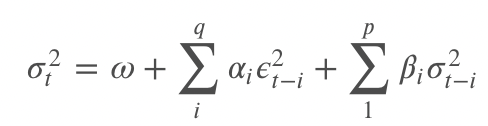

trong đó 𝜎^2𝑡
là phương sai tại bước thời gian t và 𝜖2^𝑡−𝑖
là các sai số mô hình tại bước thời gian t-1

GARCH(1,1) chỉ chứa các thuật ngữ trễ bậc 1 và công thức toán học cho nó là:

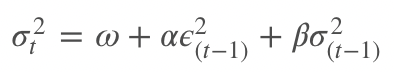

trong đó 𝛼
, 𝛽
và 𝜔
tổng cộng lên 1, và 𝜔
là phương sai dài hạn.

(Tham khảo: Positional Option Trading - Euan Sinclair)

GARCH thường được coi là một cải tiến sáng tạo so với việc giả định một cách ngây thơ rằng biến động tương lai sẽ giống như quá khứ, nhưng cũng được một số chuyên gia trong lĩnh vực biến động coi là quá được đánh giá là người dự báo. Mô hình GARCH bắt kịp những đặc điểm quan trọng của biến động: biến động vào ngày mai sẽ gần với biến động hiện tại (tụ tập), và biến động trong dài hạn có thể sẽ hồi phục về trung bình (nghĩa là nó sẽ gần với trung bình dài hạn lịch sử).

*3.1. GARCH Cơ Bản*

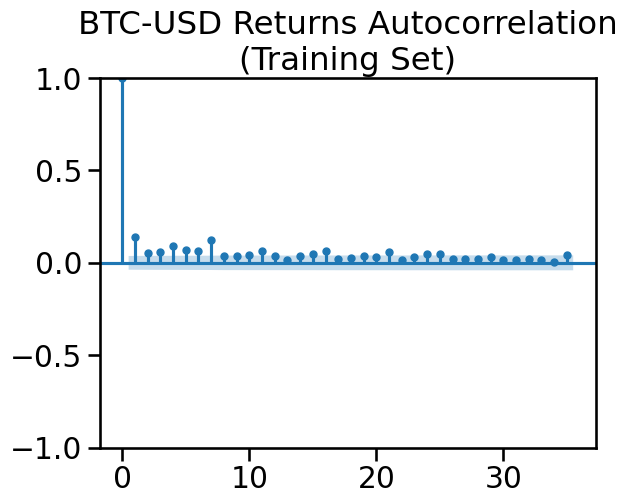

In [ ]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2,
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

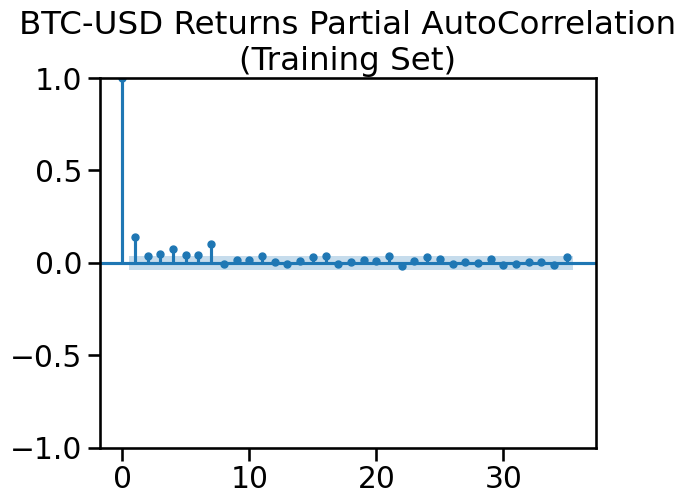

In [ ]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2,
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

In [ ]:
from arch import arch_model

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7436.21
Distribution:                  Normal   AIC:                           14904.4
Method:            Maximum Likelihood   BIC:                           14999.3
                                        No. Observations:                 2777
Date:                Sun, Oct 15 2023   Df Residuals:                     2776
Time:                        02:31:08   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2203  5.954e-02      3.701  2.150e-04 [  0.104,  0.3

Sử dụng mức ý nghĩa 0.05, không có hệ số nào dường như có ý nghĩa thống kê (bởi vì các giá trị p-values P > |t| đều lớn hơn 0.05). Do đó, tôi sẽ giảm giá trị của p và q xuống còn 1 để xem liệu điều đó có giúp ích không.

In [ ]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7455.38
Distribution:                  Normal   AIC:                           14918.8
Method:            Maximum Likelihood   BIC:                           14942.5
                                        No. Observations:                 2777
Date:                Sun, Oct 15 2023   Df Residuals:                     2776
Time:                        02:31:16   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2250  6.111e-02      3.681  2.322e-04 [  0.105,  0.3

Tất cả các hệ số dường như đều có ý nghĩa thống kê bây giờ.

Sau khi được điều chỉnh với dữ liệu huấn luyện (tỷ lệ phần trăm lợi nhuận), mô hình GARCH dự báo chứa một thuộc tính biến động có điều kiện ước lượng cho phần huấn luyện của chuỗi thời gian. Tôi sẽ tiến hành điều chỉnh - biến đổi bộ tỷ lệ để phù hợp với dữ liệu huấn luyện của các mảng biến động có điều kiện, và sau đó vẽ biểu đồ để so sánh với biến động thực tế được tính ở trên (cũng đã được chuẩn hóa) x_train_scaled.

In [ ]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [ ]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

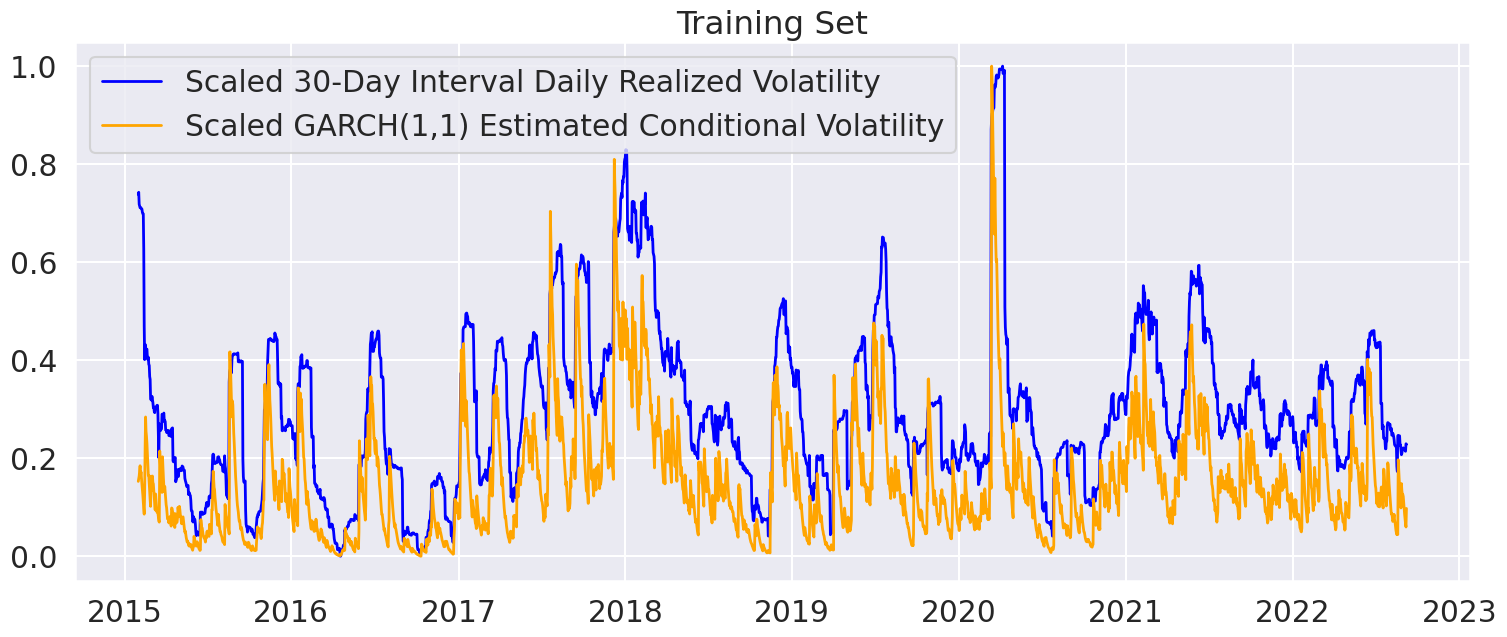

In [ ]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

*3.1.1. Dự Báo Dựa Trên Phân Tích*

(Nguồn: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html)

Tôi đang thực hiện việc dự báo một bước cuối bằng cách điều chỉnh lại mô hình cho TẤT CẢ các điểm dữ liệu có sẵn cho đến một bước thời gian nhất định trước khi tạo ra dự báo cho n_future ngày tiếp theo. Ví dụ, để dự báo vol_future tại bước thời gian t, tôi sẽ điều chỉnh lại mô hình cho tất cả các lợi nhuận có sẵn cho đến bước thời gian t và sau đó lấy trung bình của biến động dự báo cho một chu kỳ n_future = 7.

Các dự báo biến động từ các mô hình GARCH sử dụng tỷ lệ phần trăm lợi nhuận là trên một thang đo hoàn toàn khác so với biến động được tính từ các tỷ lệ phần trăm log. Do đó, tôi sẽ chuẩn hóa lại biến động dự báo dựa trên đầu ra conditional_volatility của mô hình từ dữ liệu huấn luyện, và chỉ so sánh các phiên bản được chuẩn hóa của biến động trên tập kiểm tra.

In [ ]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

Việc dự báo 7 ngày trong tương lai vẫn đang chậm hơn so với các giá trị mục tiêu. Tương tự như việc so sánh biến động huấn luyện ở trên, biến động dự báo từ GARCH dường như thấp hơn một chút (sau khi chuẩn hóa).

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled,
         'GARCH(1,1), Constant Mean, Normal Dist')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906


Tiếp theo, tôi sẽ kiểm tra các sai số ước lượng từ mô hình GARCH đầu tiên này.

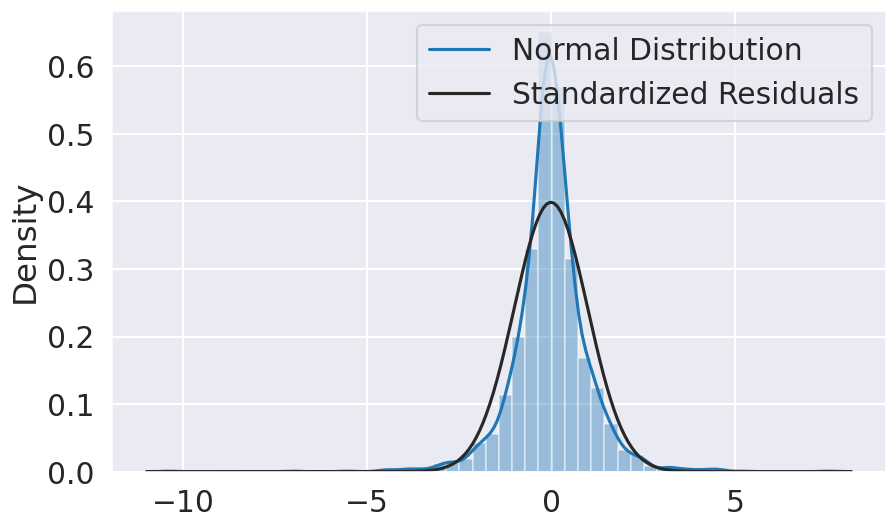

In [ ]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

(Tham khảo: https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/)

Mặc định, GARCH cơ bản dựa trên một số giả định rằng các sai số và lợi nhuận trung bình đều tuân theo phân phối chuẩn. Tuy nhiên, thường thì dữ liệu chuỗi thời gian tài chính không tuân thủ theo phân phối chuẩn, và có khả năng quan sát các giá trị dương và âm cực đại có khoảng cách xa so với trung bình.

May mắn thay, có một số tham số có thể được chỉ định trong thư viện arch_model để làm cho nó phù hợp hơn với dữ liệu tài chính thực tế:

- 'dist' có thể được đặt thành t để phân phối Student's T hoặc skewt cho phân phối Student's T lệch (phân phối Student's T cũng là phân phối đối xứng và hình chuông như phân phối chuẩn; tuy nhiên nó có đỉnh cao hơn và đuôi dày hơn, cho phép có nhiều giá trị nằm xa hơn so với trung bình).

Nhìn vào biểu đồ trên của các sai số chuẩn hóa, tôi nghĩ tôi có thể thử phân phối Student's T lệch cho việc điều chỉnh tiếp theo.

*3.2. Mô Hình GARCH với Phản Ứng Tác Động Bất Đối Xứng (GARCH Model with Asymmetric Shocks Responses)*

Mô hình GARCH cơ bản giả định rằng tin tức tích cực và tiêu cực có tác động tương tự đối với biến động. Tuy nhiên, trong thực tế, thị trường thường "đi bộ bậc lên và thang máy đi xuống". Nói cách khác, tác động thường là không đối xứng, và tác động tiêu cực thường ảnh hưởng đến biến động nhiều hơn so với tác động tích cực.

Có một thành viên khác trong họ GARCH tài chính mà xem xét phản ứng tác động bất đối xứng gọi là GJR-GARCH (viết tắt của Glosten-Jagannathan-Runkle GARCH).

Có thể sử dụng các đầu vào bổ sung để xây dựng các mô hình khác. Trong trường hợp này, bằng cách đặt o thành 1, điều này có nghĩa là mô hình sẽ bao gồm một độ trễ của tác động bất đối xứng biến đổi một mô hình GARCH thành một mô hình GJR-GARCH với động lực phương sai.

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1,
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -7086.86
Distribution:      Standardized Skew Student's t   AIC:                           14187.7
Method:                       Maximum Likelihood   BIC:                           14229.2
                                                   No. Observations:                 2777
Date:                           Sun, Oct 15 2023   Df Residuals:                     2776
Time:                                   02:32:28   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Hàm log-likelihood đã tăng khá nhiều. Hãy xem biến động có điều kiện trông như thế nào.

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

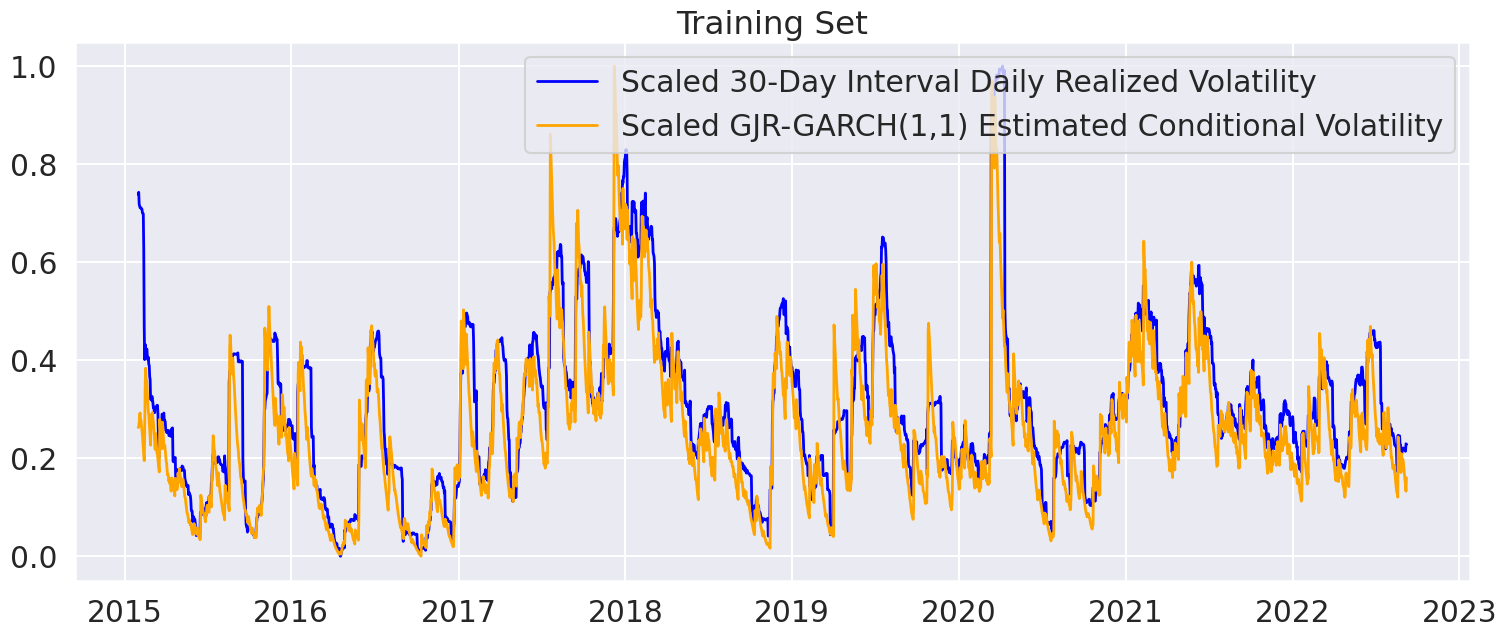

In [ ]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled,
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061


So với cài đặt GARCH(1,1) với phân phối Chuẩn, GJR-GARCH với phân phối Student's T lệch đã có sự cải thiện đáng kể và đã thu gọn khoảng cách giữa các giá trị mục tiêu và dự báo của mô hình. Điều này cũng được thể hiện qua sự cải thiện cả về RMSPE và RMSE trên tập dữ liệu kiểm tra.


Rất tiếc là tôi vẫn chưa thể đạt được kết quả gần với Dự báo Ngây thơ (Naive Forecasting).

*3.3. TARCH*

(Tham khảo: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html#Specifying-Common-Models)

Có một thành viên khác trong họ GARCH được gọi là TARCH, viết tắt của Threshold Autoregressive Conditional Heteroskedasticity (và cũng được biết đến là ZARCH). Mô hình TARCH sử dụng giá trị tuyệt đối của biến động (thay vì bình phương). Mô hình này được chỉ định bằng cách sử dụng power=1.0 vì công suất mặc định, 2.0, tương ứng với quy trình phương sai tiến hóa dưới dạng bình phương. Ngoài ra, tác động bất đối xứng cũng được tích hợp vào khung GARCH bằng cách sử dụng một biến giả.

Quy trình biến động trong một mô hình TARCH(1,1) được cho bởi:
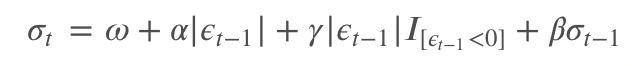

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -7086.04
Distribution:      Standardized Skew Student's t   AIC:                           14186.1
Method:                       Maximum Likelihood   BIC:                           14227.6
                                                   No. Observations:                 2777
Date:                           Sun, Oct 15 2023   Df Residuals:                     2776
Time:                                   02:34:03   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Hàm log-likelihood cũng như các chỉ số AIC/BIC khá tương tự so với mô hình GJR-GARCH. Tiếp theo, tôi sẽ kiểm tra biến động có điều kiện ước lượng so với vol_current được chuẩn hóa.

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

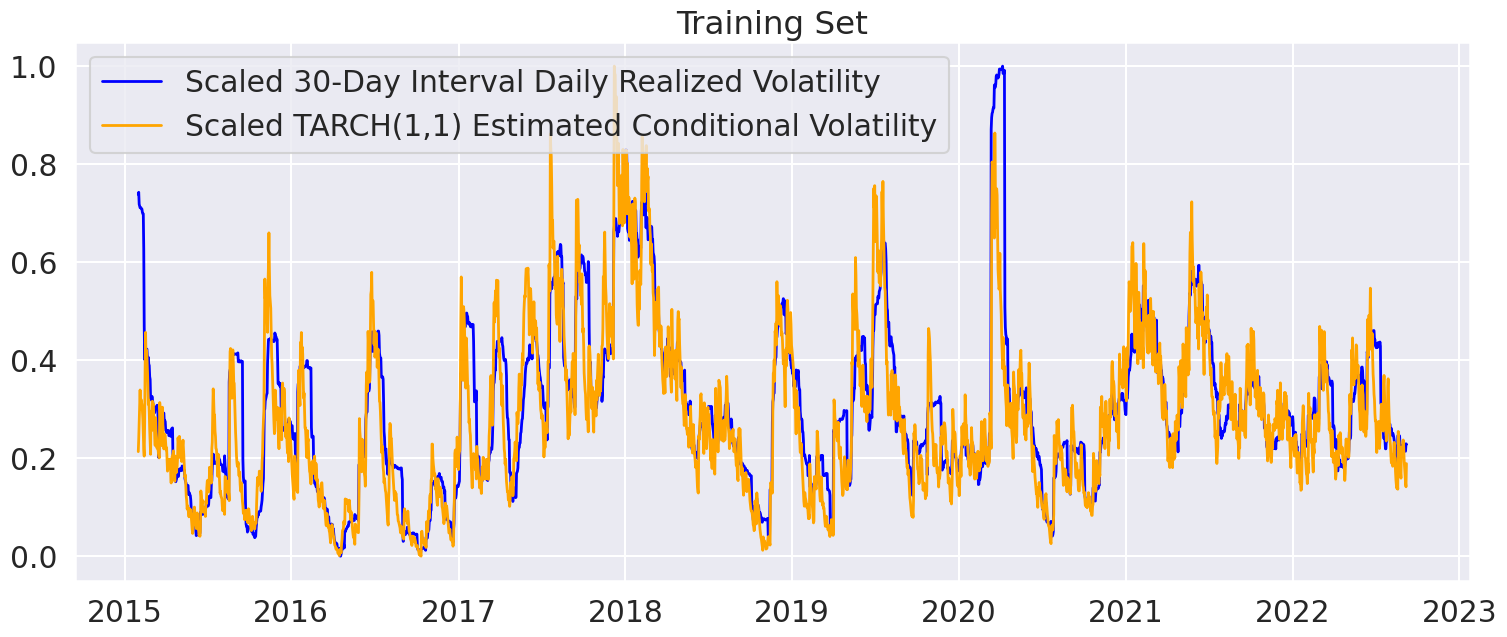

In [ ]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

*3.3.1. Dự báo Dựa trên Bootstrap cho TARCH(1,1)*

(Tham khảo: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html#TARCH)

Các mô hình TARCH không có dự báo dạng đóng (phân tích) cho các ngắn hạn lớn hơn 1, do đó cần sử dụng phương pháp mô phỏng hoặc Bootstrap.

Dự báo dựa trên Bootstrap gần như tương tự như dự báo dựa trên mô phỏng ngoại trừ việc các giá trị được sử dụng để mô phỏng quy trình được tính từ dữ liệu lịch sử thay vì sử dụng phân phối giả định của các sai số. Dự báo được tạo ra bằng phương pháp này cũng trả về một ARCHModelForecastSimulation chứa thông tin về các đường mô phỏng.

Dự báo một bước của TARCH dường như gây ra một số vấn đề về hội tụ. Tôi vẫn muốn xem kết quả dù vậy.

Biến động dự báo dường như đã bắt kịp với mục tiêu tốt hơn so với tất cả các mô hình khác đã thực hiện. Điều này là một dấu hiệu tích cực...

*3.3.3. Tinh chỉnh Siêu tham số cho TARCH*

Tiếp theo, tôi sẽ tạo ra một loạt giá trị cho p, q và o từ 0 đến 3 (bao gồm), và sau đó ghi lại hiệu suất của mỗi mô hình trên dữ liệu chưa nhìn thấy bằng RMSPE. Vì p không thể có giá trị là 0, tôi sẽ loại nó khỏi danh sách các hoán vị.

In [ ]:
import itertools

Vậy là (1,2,0) cho thấy RMSPE thấp nhất trên tập kiểm tra so với tất cả các biến thể mà tôi đã thử. Tôi sẽ tạo ra một mô hình TARCH khác với các tham số này để xem kết quả sẽ như thế nào.

*3.4. Mô hình GARCH cuối cùng - TARCH(1,2)*

Tôi sẽ huấn luyện một tập hợp khác của mô hình TARCH bằng cách sử dụng các giá trị p/q/o được tìm thấy từ việc điều chỉnh ở trên.

**4. Mạng Nơ-ron**

Trong khi GARCH vẫn được coi là tiêu chuẩn vàng cho dự báo biến động trong các tổ chức tài chính truyền thống, thì gần đây đã có sự gia tăng đáng kể về số lượng các chuyên gia và nhà nghiên cứu chuyển hướng đến Học Máy, đặc biệt là Mạng Nơ-ron, để có cái nhìn sâu hơn về thị trường tài chính.

(Tham khảo: Giao dịch tùy vị trí (Positional Option Trading- Euan Sinclair))

Lý thuyết của các nhà giao dịch về thị trường vốn được coi là tích hợp (Giả thuyết thị trường hiệu quả hay EMH) khẳng định rằng giá cổ phiếu phản ánh mọi thông tin và việc liên tục vượt qua toàn bộ thị trường là không thể. Thị trường càng hiệu quả, lợi nhuận càng ngẫu nhiên và không thể đoán trước được, và do đó, một thị trường hoàn toàn hiệu quả sẽ hoàn toàn không thể đoán trước.

Có những lập luận khác chống lại EMH, và một trong những lập luận nổi bật nhất dựa trên Tài chính Hành vi: so với lịch sử của con người kéo dài 200.000 năm, thì thị trường chứng khoán chưa tồn tại lâu. Ví dụ, tùy chọn cổ phiếu chỉ được giao dịch trên thị trường thanh khoản, minh bạch kể từ khi CBOE mở cửa vào năm 1973; và tuổi thọ trung bình của một công ty S&P500 là khoảng 20 năm. Điều đó có nghĩa là một số xu hướng tâm lý của con người đã có 200.000 năm bằng chứng đằng sau, và rằng nhiều sự biến động của thị trường do hành vi của các nhà đầu tư sẽ có thể lặp lại vào một thời điểm sau này. Do đó, hệ thống thị trường không thể hoàn toàn ngẫu nhiên, nó phải có một số mẫu. Những mẫu này cực kỳ khó khăn để khai thác do sự tương tác đa dạng của các yếu tố và sự thúc đẩy thị trường.

Sẽ thú vị để xem mạng nơ-ron hoạt động như thế nào so với các mô hình truyền thống GARCH.

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from decimal import Decimal

Đối với Mạng Nơ-ron, thay vì đưa tất cả các điểm dữ liệu có sẵn vào mạng cùng một lúc, tôi sẽ sử dụng một cửa sổ nhìn ngắn để trích xuất các mảng đầu vào và đầu ra mục tiêu. Tôi sẽ chỉ sử dụng một giá trị bước nhảy bằng 1 để đảm bảo tôi nhận được tất cả các kết hợp đầu vào và đầu ra có sẵn vì 2500 điểm dữ liệu thực sự không phải là rất nhiều để dành.

Đây là một minh họa của cửa sổ trượt:

In [ ]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [ ]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

Để tạo ra các dự đoán bằng cách sử dụng Mạng Nơ-ron, tôi sẽ sử dụng lại khái niệm về cửa sổ trượt:

Điều này có nghĩa là để tạo ra dự đoán tương lai cho một bước thời gian t, tôi sẽ cần quay lại thời điểm trước đó và thu thập các điểm dữ liệu n_past cuối cùng (từ bước thời gian t - n_past + 1 đến t bao gồm cả t). Đó là lý do tại sao hình dạng của các đầu vào vào các Mạng Nơ-ron này cần phải là [kích thước nhóm, n_past, 1].

In [ ]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [ ]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [ ]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

# **Bayesian optimization will be applied using kerastuner.**

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 6.9 MB/s eta 0:00:00


**Neural Network**

In this section, we build a neural network which includes historical volatility as an input variable.
Other option-related variables are also included in order to predict implied volatility.

We will use a couple of different neural network.

- Vanilla NN
- LSTM
- GRU

***Hyperparameter tuning***

Bayesian optimization will be applied using kerastuner.

In [ ]:
from kerastuner import BayesianOptimization

# Function 'model_builder' builds and compiles neural network with given hyperparameters

# vanilla nn
def nn_builder(hp):
    # hp
    UNITS = hp.Int('UNITS', min_value = 16, max_value = 128, step = 16)
    ACTIVATION_1 = hp.Choice('ACTIVATION',values = ['relu','linear','tanh'])
    ACTIVATION_2 = hp.Choice('ACTIVATION',values = ['relu','linear','tanh'])

    # model instance
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = UNITS, activation = ACTIVATION_1),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(1, activation = ACTIVATION_2)
    ])

    # compile
    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = 'mse', metrics = ['mae'])

    return model

# lstm
def lstm_builder(hp):
    # hp
    UNITS_1 = hp.Int('UNITS_1', min_value = 16, max_value = 128, step = 16)
    UNITS_2 = hp.Int('UNITS_2', min_value = 8, max_value = 32, step = 8)
    ACTIVATION = hp.Choice('ACTIVATION',values = ['relu','linear','tanh'])

    # model instance
    model = tf.keras.Sequential([
        # input_shape = (time_steps, # of features)
        tf.keras.layers.LSTM(units = UNITS_1, input_shape = (None, x_train.shape[2]), return_sequences = False),
        tf.keras.layers.Dense(UNITS_2, activation = ACTIVATION),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(1, activation = 'linear')
    ])

    # compile
    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = 'mse', metrics = ['mae'])

    return model

# gru
def gru_builder(hp):
    # hp
    UNITS_1 = hp.Int('UNITS_1', min_value = 16, max_value = 128, step = 16)
    UNITS_2 = hp.Int('UNITS_2', min_value = 8, max_value = 32, step = 8)
    ACTIVATION = hp.Choice('ACTIVATION',values = ['relu','softmax','linear'])

    # model instance
    model = tf.keras.Sequential([
        # input_shape = (time_steps, # of features)
        tf.keras.layers.GRU(units = UNITS_1, input_shape = (None, x_train.shape[2]), return_sequences = False),
        tf.keras.layers.Dense(UNITS_2, activation = ACTIVATION),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(1, activation = 'linear')
    ])

    # compile
    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = 'mse', metrics = ['mae'])

    return model

In [ ]:
# Implement earlystopping with keras callback

PATIENCE = 5 # number of epochs with no improvement after which training will be stopped.

Earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta = 0.001,
                                              patience=PATIENCE,
                                              mode='min',
                                              restore_best_weights=True)

In [ ]:
print(x_train.shape)

(2762,)


In [ ]:
# Search hyperparameters
SEED = 2023

# NN
tuner_nn = BayesianOptimization(nn_builder,
                                objective = 'val_loss',
                                max_trials = 20,
                                seed = SEED,
                                directory = 'kerastuner',
                                overwrite = True
                                )

tuner_nn.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

## Build model based on the optimized hyperparameters
besthp_nn = tuner_nn.get_best_hyperparameters()[0]
model_nn = tuner_nn.hypermodel.build(besthp_nn)


# lstm
tuner_lstm = BayesianOptimization(lstm_builder,
                            objective = 'val_loss',
                            max_trials = 20,
                            seed = SEED,
                            directory = 'kerastuner')

tuner_lstm.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

## Build model based on the optimized hyperparameters
besthp_lstm = tuner_lstm.get_best_hyperparameters()[0]
model_lstm = tuner_lstm.hypermodel.build(besthp_lstm)


# gru
tuner_gru = BayesianOptimization(gru_builder,
                            objective = 'val_loss',
                            max_trials = 20,
                            seed = SEED,
                            directory = 'kerastuner')

tuner_gru.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

## Build model based on the optimized hyperparameters
besthp_gru = tuner_gru.get_best_hyperparameters()[0]
model_gru = tuner_gru.hypermodel.build(besthp_gru)

Reloading Tuner from kerastuner/untitled_project/tuner0.json


IndexError: ignored

**Train model**

In [ ]:
# Colors designated to each model
palette = default_clrs[:4]
palette.append(default_clrs[6])

NameError: ignored

PALETTE

0: target data (Cru_Oil)

1: GARCH (benchmark)

2: GARCH-NN

3: GARCH-LSTM

4: GARCH-GRU

In [ ]:
# Ensure reproducible result
print(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Train model - NN
history = model_nn.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

# Plot loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss', color=palette[2])
plt.legend()

# Loss
print('final loss:',history.history['loss'][-1])
print('final val_loss:',history.history['val_loss'][-1])

In [ ]:
model_nn.summary()

In [ ]:
# Train model - LSTM
history = model_lstm.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

# Plot loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss',color=palette[3])
plt.legend()

# Loss
print('final loss:',history.history['loss'][-1])
print('final val_loss:',history.history['val_loss'][-1])

In [ ]:
model_lstm.summary()

In [ ]:
# Train model - GRU
history = model_gru.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), verbose=0, callbacks=[Earlystopping])

# Plot loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss',color=palette[4])
plt.legend()

# Loss
print('final loss:',history.history['loss'][-1])
print('final val_loss:',history.history['val_loss'][-1])

In [ ]:
model_gru.summary()

**Result**

In [ ]:
# Data for comparison
target_date = test_org['Date'].iloc[TIME_STEPS:]
target_vkospi = test_org['VKOSPI'].iloc[TIME_STEPS:]
predictions_hv = test_org['Historical Volatility'].iloc[TIME_STEPS:]

# Function to scale back predictions
def scale_back(predictions):
    predictions = [prediction[0] for prediction in predictions] # unpack array

    # scale back
    mean_vol = train_org['VKOSPI'].mean()
    std_vol = train_org['VKOSPI'].std()
    predictions = [prediction * std_vol + mean_vol for prediction in predictions]

    return predictions

# Predict
predictions_nn = scale_back(model_nn.predict(x_test))
predictions_lstm = scale_back(model_lstm.predict(x_test))
predictions_gru = scale_back(model_gru.predict(x_test))

# pd.Series-ization
predictions_nn = pd.Series(predictions_nn, index=target_vkospi.index, name='predictions_nn')
predictions_lstm = pd.Series(predictions_lstm, index=target_vkospi.index, name='predictions_lstm')
predictions_gru = pd.Series(predictions_gru, index=target_vkospi.index, name='predictions_gru')

In [ ]:
# Plot
fig1, ax1 = plt.figure(figsize=(20,7)), plt.axes()
fig2, ax2 = plt.figure(figsize=(20,7)), plt.axes()
fig3, ax3 = plt.figure(figsize=(20,7)), plt.axes()
fig4, ax4 = plt.figure(figsize=(20,7)), plt.axes()

# target data
ax1.plot(target_date, target_vkospi, label='VKOSPI (target data)')
ax2.plot(target_date, target_vkospi, label='VKOSPI (target data)')
ax3.plot(target_date, target_vkospi, label='VKOSPI (target data)')
ax4.plot(target_date, target_vkospi, label='VKOSPI (target data)')

# predictions
ax1.plot(target_date, predictions_hv, label='GARCH',color=palette[1])
ax2.plot(target_date, predictions_nn, label='GARCH-NN',color=palette[2])
ax3.plot(target_date, predictions_lstm, label='GARCH-LSTM',color=palette[3])
ax4.plot(target_date, predictions_gru, label='GARCH-GRU',color=palette[4])

# show
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

**MSE and MAE**

In [ ]:
# Calculate error
def cal_MSE(predictions):
    errors = (predictions - target_vkospi)**2
    return errors.mean()

def cal_MAE(predictions):
    errors = abs(predictions - target_vkospi)
    return errors.mean()


# Print error
print('GARCH')
print('MSE:',cal_MSE(predictions_hv))
print('MAE:',cal_MAE(predictions_hv))

print('GARCH-NN')
print('MSE:',cal_MSE(predictions_nn))
print('MAE:',cal_MAE(predictions_nn))

print('GARCH-LSTM')
print('MSE:',cal_MSE(predictions_lstm))
print('MAE:',cal_MAE(predictions_lstm))

print('GARCH-GRU')
print('MSE:',cal_MSE(predictions_gru))
print('MAE:',cal_MAE(predictions_gru))


**Number of best predictions**

In [ ]:
# Compare day by day

# error list
errors_hv = abs(target_vkospi - predictions_hv)
errors_nn = abs(target_vkospi - predictions_nn)
errors_lstm = abs(target_vkospi - predictions_lstm)
errors_gru = abs(target_vkospi - predictions_gru)

# count the best models
best_models = []
for i in range(len(errors_hv)):
    each_predictions = [errors_hv.iloc[i], errors_nn.iloc[i], errors_lstm.iloc[i], errors_gru.iloc[i]]
    best_models.append(each_predictions.index(min(each_predictions)))

best_counts = [best_models.count(i) for i in range(4)]


# plot
fig, ax = plt.figure(), plt.axes()
ax.pie(best_counts, labels=['GARCH','GARCH-NN','GARCH-LSTM','GARCH-GRU'], autopct='%.0f%%', startangle=90, colors=palette[1:])
plt.title('Number of days in which it performed the best')
plt.show()

In [ ]:
# direction arrays
directions_vkospi = target_vkospi - target_vkospi.shift()
directions_hv = predictions_hv - predictions_hv.shift()
directions_nn = predictions_nn - predictions_nn.shift()
directions_lstm = predictions_lstm - predictions_lstm.shift()
directions_gru = predictions_gru - predictions_gru.shift()

# multiplicate element-wise, and count the positivie elements
def count_pos(series):
    count = 0
    for x in series:
        if x>0:
            count += 1
    return count

direction_counts = [511,0,0,0,0]
direction_counts[1] = count_pos(directions_hv * directions_vkospi)
direction_counts[2] = count_pos(directions_nn * directions_vkospi)
direction_counts[3] = count_pos(directions_lstm * directions_vkospi)
direction_counts[4] = count_pos(directions_gru * directions_vkospi)

# plot
fig, ax = plt.figure(), plt.axes()
ax.bar(['Total Days','GARCH','GARCH-NN','GARCH-LSTM','GARCH-GRU'],direction_counts, color=palette)
plt.title('Number of days in which it predicted the right direction(up or down)')
plt.show()

# direction prediction accuracy
print('GARCH')
print(direction_counts[1] / direction_counts[0]*100,'%')
print('GARCH-NN')
print(direction_counts[2] / direction_counts[0]*100,'%')
print('GARCH-LSTM')
print(direction_counts[3] / direction_counts[0]*100,'%')
print('GARCH-GRU')
print(direction_counts[4] / direction_counts[0]*100,'%')

# **Kết thúc vấn đề này cần nghiên cứu thêm Bayesian optimization**


*4.1. Thước Đo Cơ Bản cho Mạng Nơ-ron - Mạng Nơ-ron Kết Nối Đầy Đủ(Fully Connected Network)*

Đây về cơ bản là Hồi quy Tuyến Tính.

(Huấn luyện trực tiếp bằng sự biến đổi tỉ lệ cảm biến sẽ tạo ra giá trị RMSPE vô cùng, vì vậy tôi sẽ sử dụng cả biến đổi tỉ lệ cảm biến ban đầu và điều chỉnh các dự báo sau).

Tôi sẽ bắt đầu bằng cách sử dụng một cửa sổ n_past có độ dài 14, sau đó tinh chỉnh giá trị đó dựa trên kết quả của các mô hình của tôi.

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse',
              optimizer='adam',
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 15 (60.00 Byte)
Trainable params: 15 (60.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# FIT MODEL TO TRAINING DATASET
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size,
                      shuffle=True)

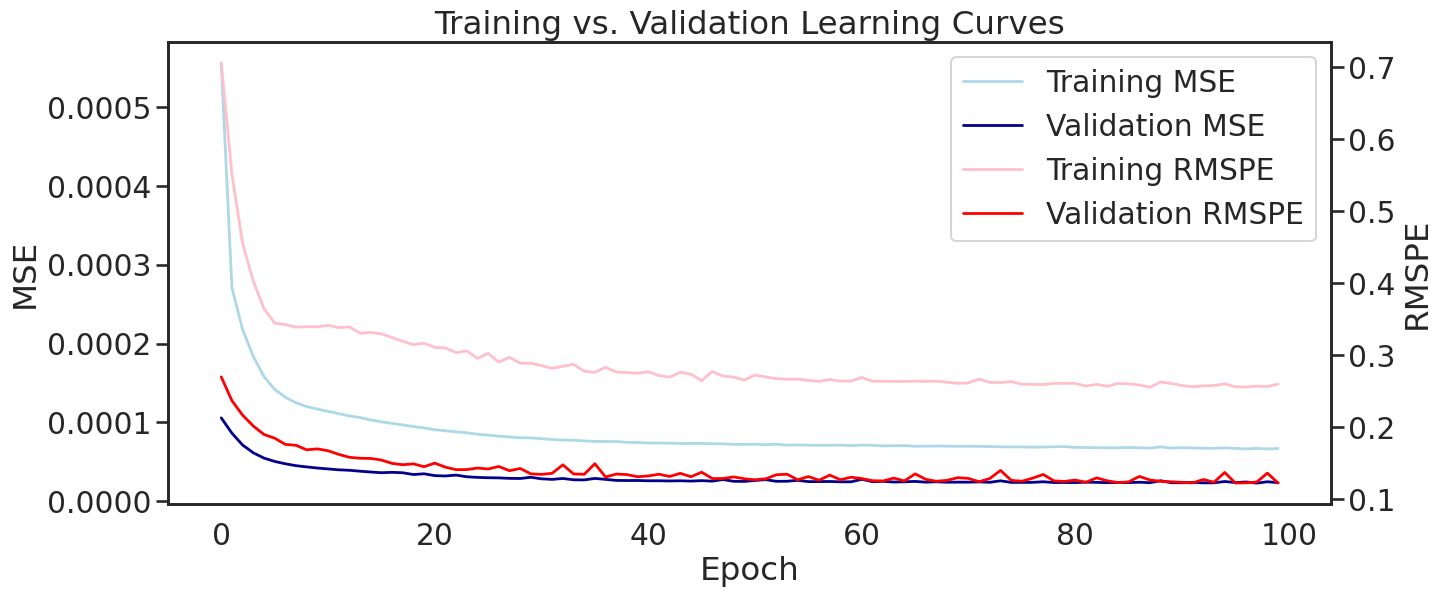

In [ ]:
viz_train_val_metrics(snn_1_res)

In [ ]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 [==============================] - 0s 2ms/step


Dự báo đang theo sát rất chặt đường biến động hiện tại, nhưng đa phần là đang kém hơn so với các giá trị mục tiêu của tôi.

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061
4,"Simple LR Fully Connected NN, n_past=14",0.617320,0.063809


Một Mạng Nơ-ron Hoàn toàn Kết nối đơn giản không thể nói là thực hiện quá tệ. RMSPE trên tập kiểm tra sau 100 epoch của việc huấn luyện và chỉ có một chút điều chỉnh đã giảm xuống chỉ hơn mô hình TARCH(1,2) tốt nhất trên RMSPE, và thậm chí thấp hơn trên RMSE.

**4.2. Mạng NLSTM Đơn biến-Univariate Long Short-Term Memory (UV_LSTM)**

Có một lớp của Mạng Nơ-ron Tích chập gọi là Mạng Nơ-ron Tích chập Tái phát (RNN) có thể "dự đoán tương lai". RNN hoạt động tốt với dữ liệu chuỗi thời gian, chẳng hạn như giá cổ phiếu, và thậm chí có thể xử lý câu, tài liệu, mẫu âm thanh như đầu vào. Một ứng dụng khác của RNN là trong các hệ thống lái tự động, nơi chúng được sử dụng để dự đoán quỹ đạo của phương tiện và giúp tránh tai nạn.

Tại mỗi bước thời gian t, neuron tái phát nhận đầu vào 𝑥𝑡 cũng như đầu ra của nó từ bước thời gian trước đó 𝑦𝑡−1 . Vì đầu ra của một neuron tái phát là một hàm của tất cả các đầu vào từ các bước thời gian trước đó, nó có một hình dạng của bộ nhớ và có khả năng lưu giữ một số thông tin qua thời gian.

Tuy nhiên, do một số biến đổi mà dữ liệu trải qua khi di chuyển xuống RNN, một số thông tin sẽ bị mất ở mỗi bước thời gian, và đối với một chuỗi dài, trạng thái RNN chứa ít thông tin từ các đầu vào đầu tiên.

Long Short-Term Memory (LSTM) được đề xuất vào năm 1997 bởi Sepp Hochreiter và Jurgen Schmidhuber. Phần chính của LSTM là mạng có thể học được điều quan trọng và cần được lưu trữ trong trạng thái dài hạn, và điều gì có thể bị bỏ qua. LSTM trông rất giống một ô RNN thông thường, nhưng trạng thái của nó được chia thành 2 vector:

- ℎ𝑡 - cho trạng thái ngắn hạn
- 𝑐𝑡 - cho trạng thái dài hạn

LSTM là một hộp đen, và có thể được sử dụng như một ô cơ bản của Mạng Nơ-ron Tích chập (RNN). Tuy nhiên, nó thường thực hiện tốt hơn, giúp quá trình huấn luyện tiến triển nhanh hơn, và cũng phát hiện các phụ thuộc dài hạn trong dữ liệu.

LSTM sử dụng một cách triển khai tối ưu hóa khi chạy trên một GPU, đó là lý do tại sao nên khuyến nghị chạy phần thứ hai của sổ ghi chú này trên Google Colab.

Trước tiên, tôi sẽ sử dụng cửa sổ nhìn lại cũng như các Mạng Nơ-ron Tích chập trước đó (30), và sau đó, tùy thuộc vào kết quả, tôi sẽ cố gắng điều chỉnh giá trị đó sau.

Mô hình LSTM đầu tiên sẽ rất đơn giản với chỉ 1 lớp LSTM ẩn có 20 đơn vị. Tôi sử dụng trình tối ưu hóa adam tiêu chuẩn ở đây, và sẽ thử nghiệm với các trình tối ưu hóa khác nếu cần.

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

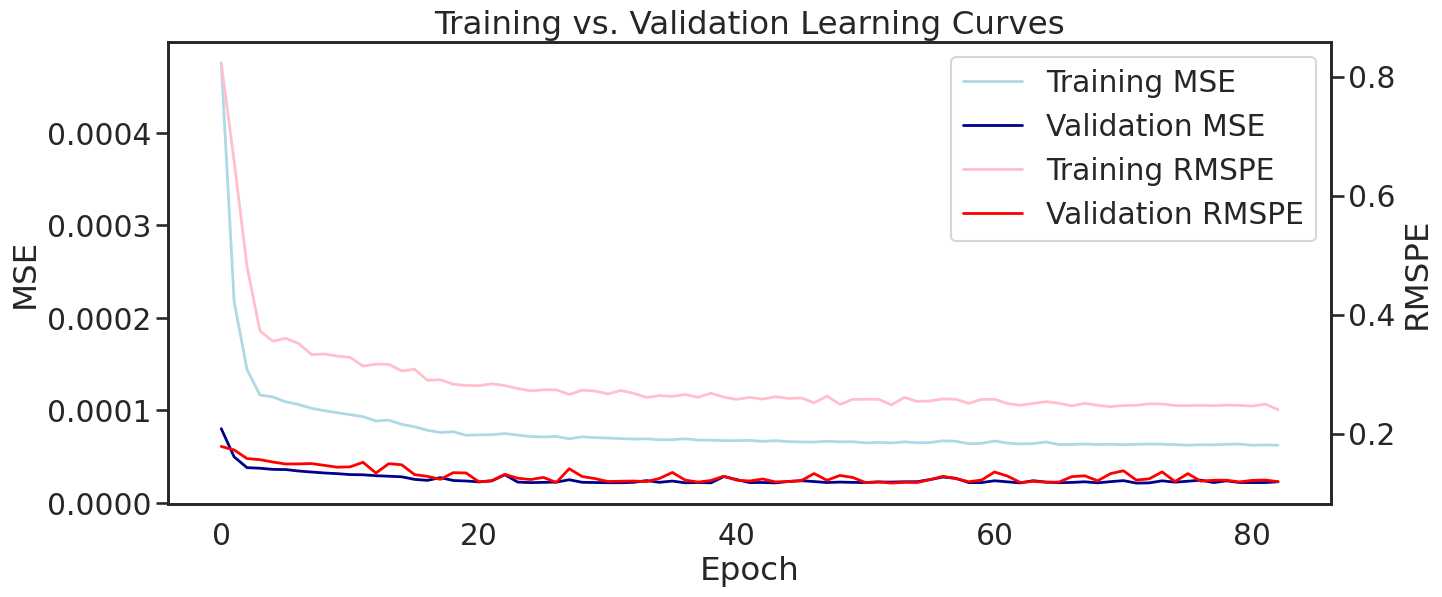

In [ ]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

RMSPE kiểm tra thực tế thấp hơn so với RMSPE huấn luyện, nhưng tổng thể, tất cả các đường trừ RMS huấn luyện đều khá không ổn định.

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 1s 5ms/step


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled,
         f"LSTM 1 layer 20 units, n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061
4,"Simple LR Fully Connected NN, n_past=14",0.617320,0.063809
5,"LSTM 1 layer 20 units, n_past=14",0.622585,0.062673


Một lần nữa, dự đoán theo dõi vol_current khá gần, và đường dự đoán đã được làm mịn so với dự đoán của mạng NN hoàn toàn kết nối (nghĩa là nó ít nhiễu hơn), nhưng vẫn còn đang trễ so với mục tiêu mong muốn.

Mô hình LSTM đơn giản với 1 lớp chỉ cải thiện một chút so với mạng kết nối đầy đủ về RMSPE, và thực tế có chỉ số RMSE cao hơn so với mô hình LR NN đơn giản ở trên.

**4.3. Mạng LSTM đơn biến hai chiều - UV_BiLSTM(Univariate Bidirectional LSTM)**

(Reference: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence)

Nghiên cứu tiếp theo cho thấy có một loại LSTM mở rộng được gọi là LSTM hai chiều (Bidirectional LSTM), có thể tiềm năng hơn trong trường hợp này bằng cách cung cấp ngữ cảnh bổ sung cho các mô hình. Vì tất cả các bước thời gian của chuỗi đầu vào đã có sẵn, LSTM hai chiều có thể huấn luyện 2 LSTM thay vì 1 trên cùng một chuỗi đầu vào:

- LSTM đầu tiên hoạt động trên đầu vào nguyên gốc.
- LSTM thứ hai hoạt động trên bản sao ngược lại của đầu vào.

Điều này có thể giúp cung cấp ngữ cảnh bổ sung cho mạng, và thường tạo ra quá trình học nhanh và toàn diện hơn trên vấn đề.

LSTM cho phép duy trì một số kỷ niệm dài hạn xuyên suốt thời gian, do đó tôi sẽ mở rộng n_past thành 1 tháng, và cũng tăng số lớp ẩn để xem liệu mô hình có thể nắm bắt được các mẫu cụ thể tốt hơn không.

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirection  (None, None, 64)          8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19105 (74.63 KB)
Trainable params: 19105 (74.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

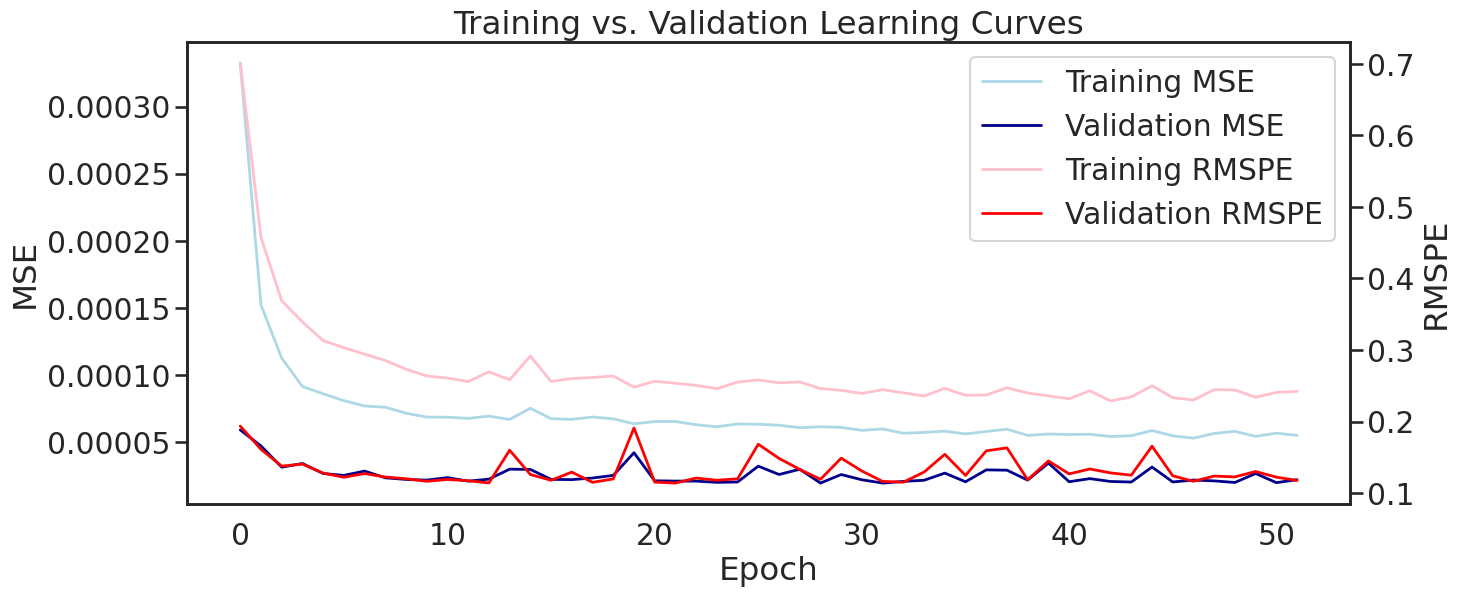

In [ ]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 [==============================] - 2s 13ms/step


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled,
         f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061
4,"Simple LR Fully Connected NN, n_past=14",0.617320,0.063809
5,"LSTM 1 layer 20 units, n_past=14",0.622585,0.062673
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.587727,0.059264


Mô hình 2 lớp LSTM hai chiều với cửa sổ quan sát 30 ngày đã vượt qua mô hình GARCH tốt nhất (TARCH(2,2)) được tìm thấy ở trên, điều này có nghĩa là tôi có thể đang đi đúng hướng!

Trong các Sổ tay Khám phá khác của tôi, tôi đã thử nghiệm với các hàm kích hoạt và cấu trúc mạng khác nhau, như:

- Sử dụng activation='relu' hoặc activation='sigmoid'
- Tăng số lớp LSTM ẩn
- Tăng số đơn vị trong mỗi lớp LSTM
- Thêm lớp Dropout với tỷ lệ dropout khác nhau
- Thay đổi kích thước batch

Tuy nhiên, không có một trong số chúng vượt qua kiến trúc đơn giản ở trên (2 lớp LSTM hai chiều với 32 và 16 đơn vị, và n_past=30).

**4.4. Univariate Bidirectional LSTM + 1D Convolutional Layer(s)**

(Reference: Geron (2019))
Lớp Convolution 1D trượt qua nhiều kernel trên một chuỗi, tạo ra một bản đồ đặc trưng 1D cho mỗi kernel. Mỗi kernel sẽ học cách phát hiện một mẫu tuần tự rất ngắn (không dài hơn kích thước kernel).

Các lớp Convolution được thiết kế để cho phép mở rộng cửa sổ quan sát và giúp mô hình nhận diện các mẫu xa hơn trong quá khứ.

In [ ]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",
                           activation="relu",
                           input_shape=[None, 1]),
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160       
                                                                 
 bidirectional (Bidirection  (None, None, 64)          16640     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27201 (106.25 KB)
Trainable params: 27201 

In [ ]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

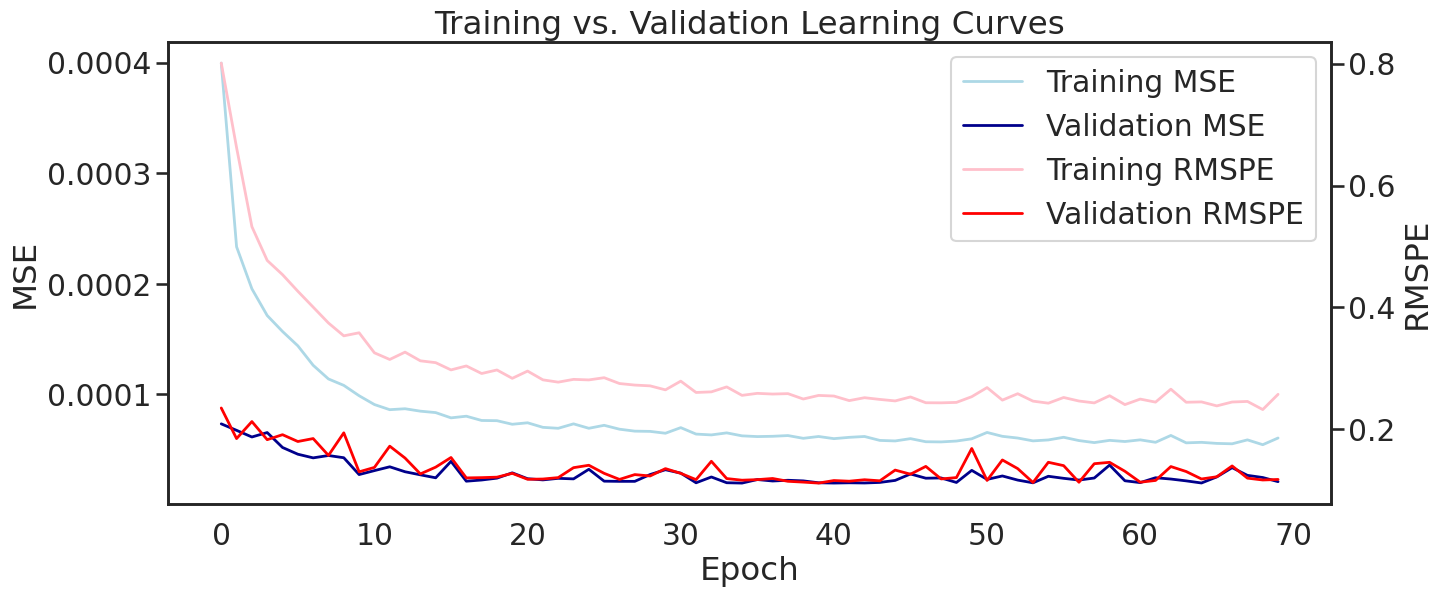

In [ ]:
# VISUALIZING TRAINING/VALIDATION METRICS
viz_train_val_metrics(lstm_3_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_3_preds = forecast(lstm_3, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

12/12 [==============================] - 3s 17ms/step


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled,
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061
4,"Simple LR Fully Connected NN, n_past=14",0.617320,0.063809
5,"LSTM 1 layer 20 units, n_past=14",0.622585,0.062673
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.587727,0.059264
7,"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",0.649781,0.064653


Vậy các lớp Convolutional thực sự không giúp ích nhiều ở đây. Cả RMSPE và RMSE đều tăng lên đáng kể, và hiệu suất tương đối tương đương với mô hình Fully Connected NN đơn giản.

(Tham khảo: Geron (2019))

Trong các Sổ tay Khám phá khác của tôi, tôi cũng đã thực nghiệm với một phiên bản đơn giản của WaveNet, một kiến trúc được đề xuất bởi Aaron van den Oord và các nhà nghiên cứu khác của DeepMind vào năm 2016.
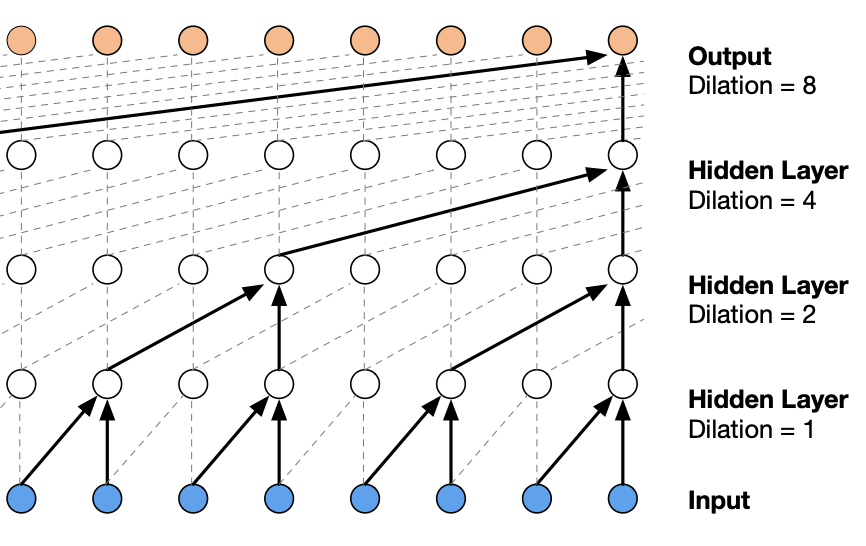

WaveNet được tạo ra bằng cách xếp các lớp Convolutional 1D lên nhau, tăng tỷ lệ co ngót lên gấp đôi ở mỗi lớp (tỷ lệ co ngót biểu thị khoảng cách giữa đầu vào của mỗi neuron hoặc sự phân tán của đầu vào của mỗi neuron). Như vậy:

- Các lớp thấp hơn học các mẫu ngắn hạn
- Và các lớp cao hơn có thể học các mẫu dài hạn

WaveNet hoạt động rất hiệu quả với các chuỗi cực kỳ lớn, đặc biệt là các mẫu âm thanh (do đó được đặt tên là WaveNet), nhưng cũng đã được phát hiện là rất thành công với dữ liệu chuỗi thời gian tài chính, trong đó các sự kiện "quan trọng" thường xuất hiện không đều và hiếm hoi (điều này có nghĩa là khoảng thời gian giữa các sự kiện đó thường biến đổi).

Phiên bản của tôi về WaveNet không thành công lắm trong việc nhận diện những thay đổi tinh tế hơn về biến động. Tôi thực sự không nghĩ rằng kiến trúc này không tốt, có thể điều quan trọng hơn là tôi chưa tìm ra cách thực hiện nó một cách chính xác và phù hợp với bộ dữ liệu của tôi. Điều này chắc chắn sẽ là một trong những ý tưởng tiềm năng để tiếp tục nghiên cứu trong tương lai.


**4.5. Tinh chỉnh Tốc độ học với Trình tối ưu hóa SGD (Learning Rate Tuning with SGD Optimizer)**

Tính tới thời điểm này, tôi chỉ sử dụng trình tối ưu hóa adam tiêu chuẩn. Sẽ thú vị để xem cách mô hình hoạt động trên một trình tối ưu hóa có thể tùy chỉnh hơn như Stochastic Gradient Descent (SGD). Tôi sẽ tiếp tục điều này với kiến trúc LSTM có hiệu suất thành công nhất cho đến nay (2 lớp LSTM hai chiều với 32 và 16 đơn vị và cửa sổ quan sát 30 ngày).

In [ ]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

# EXPONENTIALLY INCREASE LEARNING RATE
# BY THE POWER OF 10 EVERY 20 EPOCHS
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=160,
                        callbacks=[lr_schedule],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

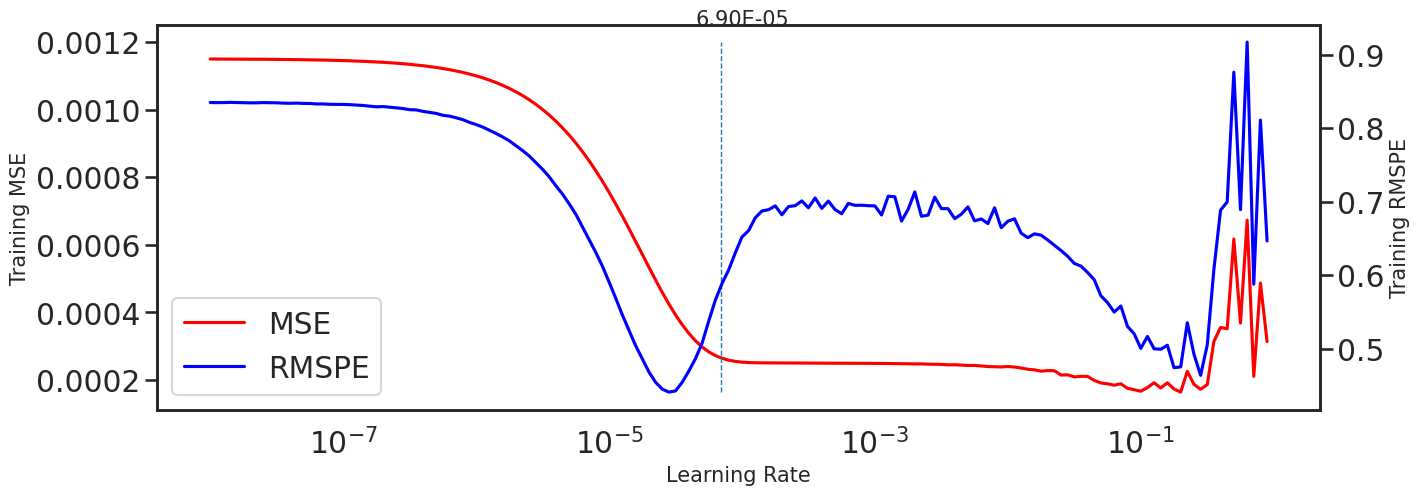

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15,5))

    # PLOT MSE - LEFT Y-AXIS
    ln1 = ax.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['loss'],
                color='red', label='MSE')
    ax.set_xlabel('Learning Rate', fontsize=15)
    ax.set_ylabel('Training MSE', fontsize=15)

    # PLOT RMSE - RIGHT Y-AXIS
    ax2 = ax.twinx()
    ln2 = ax2.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['rmspe'],
                color='blue', label='RMSPE')
    ax2.set_ylabel('Training RMSPE', fontsize=15)

    # COMBINING LALBELS FOR 2 LINES INTO 1 LEGEND
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='lower left')

    best_lr = 6.9e-5

    ax.vlines(x=best_lr, ls='--', lw=1,
            ymin=np.min(lstm_4_res.history["loss"]),
            ymax=0.0012)

    ax.text(4.5e-5, 0.00125, '%.2E' % Decimal(best_lr), fontsize=15)

    plt.show();

Tốt nhất có lẽ là tốc độ học 6.9e-5, đó là điểm giao giữa các đường RMSE và RMSPE. RMSE tiếp tục giảm ngay cả khi Tốc độ học tiến dần đến 1e-1, nhưng RMSPE bắt đầu tăng lên ở khoảng 4e-5 và trở nên rất không ổn định sau đó. Tiếp theo, tôi sẽ huấn luyện lại mô hình bằng tốc độ học tốt nhất tìm thấy ở trên.

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_4.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

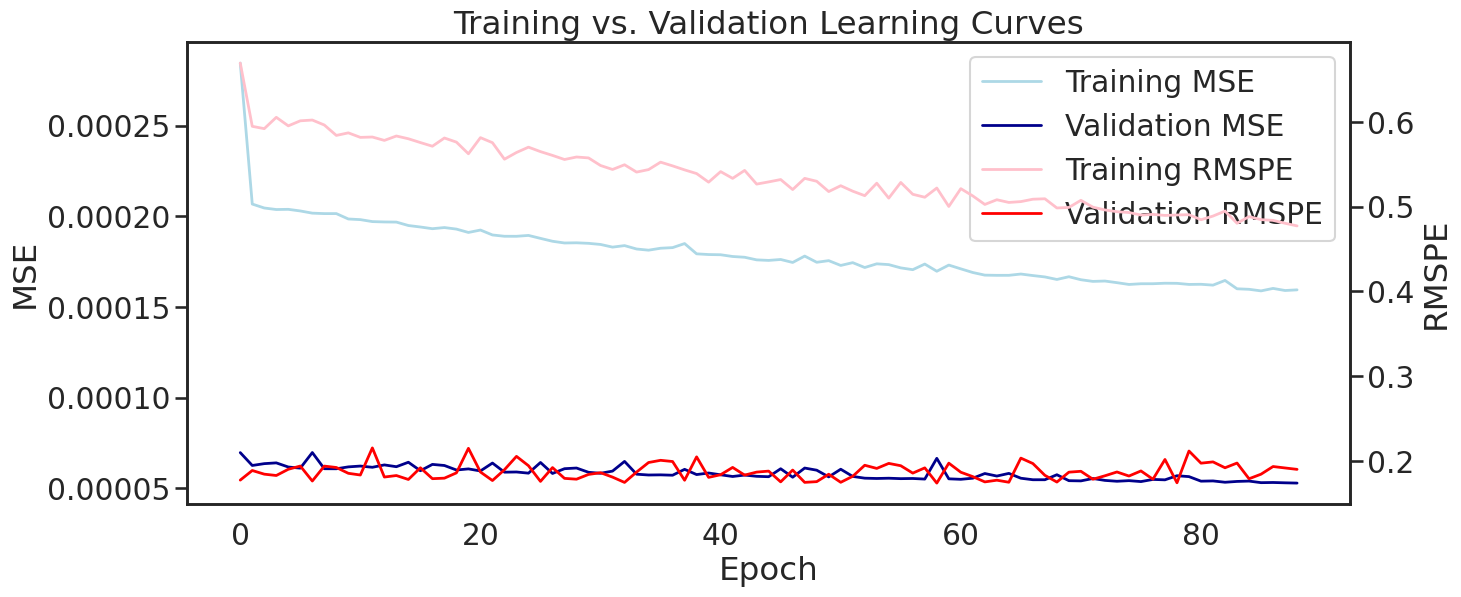

In [ ]:
# VISUALIZING TRAINING/VALIDATION LEARNING CURVES
viz_train_val_metrics(lstm_4_res)

RMSPE trên tập huấn luyện bắt đầu tăng lên sau epoch 5, nhưng điều đáng ngạc nhiên là mọi thứ khác (bao gồm cả RMSPE trên tập validation) vẫn tiếp tục giảm đến epoch 35, khi hiệu suất dừng lại.

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_4_preds = forecast(lstm_4, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_4_preds_scaled = scale(scaler_vol, lstm_4_preds)

12/12 [==============================] - 2s 14ms/step


Bộ tối ưu hóa tùy chỉnh này dường như ưu tiên xu hướng dài hạn của sự dao động trở lại giá trị trung bình. Do đó, các dự đoán dao động quanh vị trí của giá trị trung bình.

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_4_preds_scaled,
         f"2 Bidirect LSTMs (32/16), n_past={n_past}, batch={batch_size}, SGD lr={best_lr}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061
4,"Simple LR Fully Connected NN, n_past=14",0.617320,0.063809
5,"LSTM 1 layer 20 units, n_past=14",0.622585,0.062673
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.587727,0.059264
7,"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",0.649781,0.064653
8,"2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05",1.074338,0.088198


Các cài đặt cho tối ưu hóa SGD sử dụng tốt nhất tốt hơn không dường như mang lại kết quả tốt hơn so với tối ưu hóa Adam, vì vậy tiếp tục, tôi sẽ tiếp tục sử dụng Adam.

**4.6. Da bien voi LSTM-MV_LSTM (Multivariate LSTM)**

Cho đến nay, tôi chỉ sử dụng đầu vào một chiều đơn giản cho tất cả các mô hình của mình, và đối với dữ liệu tài chính, điều này có thể là không đủ. Điều này có thể là lý do tại sao hầu hết các mô hình trên không thành công trong việc mang lại kết quả tốt hơn so với Dự báo Ngây thơ. Không quan trọng có bao nhiêu tế bào thần kinh hoặc các lớp ẩn được sử dụng, hoặc kiến ​​trúc mô hình có độ phức tạp như thế nào, dữ liệu không đáng tin cậy có thể sẽ không tạo ra kết quả tốt.

Đối với phần tiếp theo, tôi sẽ thử nghiệm tạo ra Mạng Neural Đa Biến để xem liệu việc thêm các đặc trưng có thể cải thiện hiệu suất hay không.

4.6.1. Feature Engineering
Các giá Mở/Thấp/Cao/Đóng thường rất tương tự và có mối tương quan cao với nhau. Do đó, thay vì giữ tất cả chúng trong bộ dữ liệu, tôi sẽ thêm 2 đặc trưng nữa:

- Sự chênh lệch Giá Cao-Thấp(High-Low Spread) - được tính là logarit của sự khác biệt giữa giá Cao nhất và giá Thấp nhất trong ngày, tính theo phần trăm của giá Đóng cửa.
- Sự chênh lệch Giá Mở-Đóng(Open-Close Spread) - được tính là sự khác biệt giữa giá Mở và giá Đóng, tính theo phần trăm của giá Đóng cửa.

Với đặc trưng Khối lượng:

Cột Khối lượng có các giá trị rất lớn, lên đến hàng tỷ/triệu lần lớn hơn so với - các đặc trưng khác. Do đó, tôi sẽ sử dụng np.log() để lấy logarit tự nhiên của nó, và hy vọng rằng điều này sẽ biến đổi nó thành một phân phối trông "bình thường" hơn.

Sau đó, tôi sẽ loại bỏ ba cột Giá Đóng cửa, Giá Mở, Giá Cao và Giá Thấp.

In [ ]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

Những đặc trưng số này sẽ cần được chuẩn hóa sau đó vì LSTM sử dụng các hàm kích hoạt sigmoid và tanh, đây là các hàm rất nhạy cảm đối với khoảng biến đổi.

Vì vol_current đã được tạo ra từ log_returns, tôi sẽ không bao gồm log_returns trong mô hình của mình.

In [458]:
df

,Open,High,Low,Close,Volume,returns,log_returns,vol_current,vol_future,HL_sprd,CO_sprd
Date,,,,,,,,,,,
2015-01-31 00:00:00+00:00,226.440994,233.503998,216.309006,217.464005,16.966030,-3.957601,-0.040380,0.078597,0.075733,-2.537415,-0.039644
2015-02-01 00:00:00+00:00,216.867004,231.574005,212.014999,226.972000,17.187228,4.372216,0.042793,0.078996,0.075679,-2.451391,0.046595
2015-02-02 00:00:00+00:00,226.490997,242.175003,222.658997,238.229004,17.236906,4.959644,0.048406,0.076635,0.075032,-2.501997,0.051825
2015-02-03 00:00:00+00:00,237.453995,245.957001,224.483002,227.268005,17.523793,-4.601034,-0.047102,0.076269,0.074769,-2.359287,-0.042897
2015-02-04 00:00:00+00:00,227.511002,230.057999,221.113007,226.852997,17.096207,-0.182608,-0.001828,0.075940,0.074756,-3.233208,-0.002892
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-03 00:00:00+00:00,27508.251953,27667.191406,27216.001953,27429.978516,23.157564,-0.366160,-0.003668,0.013911,0.014386,-4.107504,-0.002845
2023-10-04 00:00:00+00:00,27429.074219,27826.658203,27248.105469,27799.394531,23.134109,1.346760,0.013378,0.014086,0.013991,-3.872240,0.013501
2023-10-05 00:00:00+00:00,27798.646484,28091.861328,27375.601562,27415.912109,23.197891,-1.379463,-0.013891,0.014319,0.013135,-3.644836,-0.013768


In [ ]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

In [ ]:
# Columns to plot
plot_columns = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

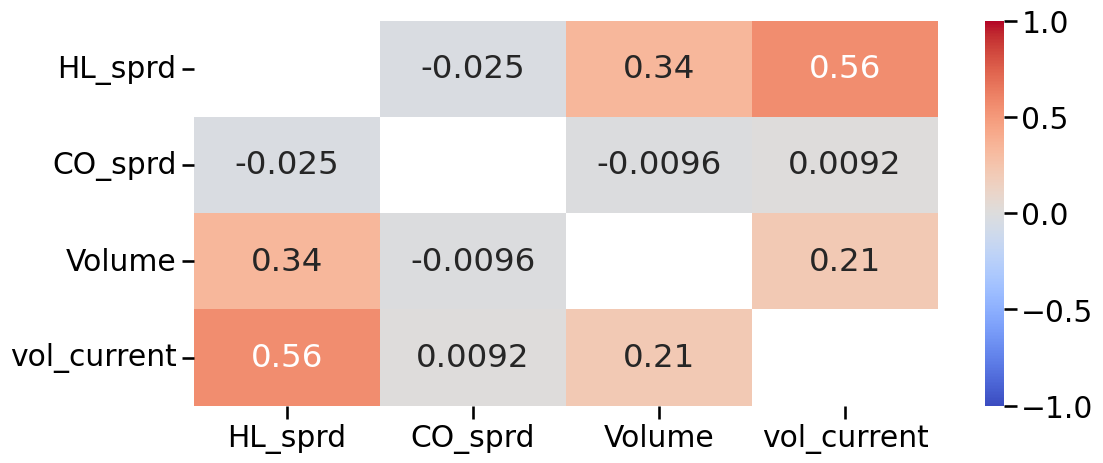

In [ ]:
# Correlation matrix
corr = df[plot_columns].corr()

mask = np.zeros_like(corr)
for i in range(mask.shape[0]):
    mask[i,i]=True
plt.figure(figsize=(12,5))
sns.heatmap(corr,annot=True,mask=mask,cmap='coolwarm',vmin=-1,vmax=1)
plt.show()

**4.6.2. Định hình lại đầu vào**

Dự đoán ở đây sẽ là dự đoán volatiliti của 7 ngày tiếp theo (cột vol_future) bằng cách sử dụng 4 biến đầu vào:

- HL_sprd (Phạm vi giá cao thấp)
- CO_sprd (Phạm vi giá mở đóng)
- Thể tích
- vol_current (Volatiliti hiện tại)

Việc định hình lại đầu vào là phần quan trọng của các mô hình LSTM đa biến này. Nói chung, đầu vào cho LSTM nên có dạng:

[batch_size, n_past, input_dims]

trong đó:

- batch_size là số điểm dữ liệu trong mỗi batch
- n_past là số bước thời gian trước đó được sử dụng để dự đoán (tạm thời tôi sẽ sử dụng cùng một giá trị như ở trên).
- input_dims là số lượng đặc trưng đầu vào (trong trường hợp này là 4)

In [ ]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [ ]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx],
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

**4.7. LSTM Đa biến 2 tầng với Bidirectional và Dropout (Multivariate 2-Layered Bidirectional LSTM with Dropout)**

Mô hình LSTM đa biến đầu tiên của tôi sẽ tương đối đơn giản với 2 tầng ẩn của LSTM Bidirectional (khá tương tự với cấu trúc không đa biến ở trên). Tuy nhiên, tôi cũng sẽ bao gồm các tầng Dropout ở giữa. Việc có nhiều đặc trưng đồng nghĩa với việc mô hình có thể dễ dàng bị quá khớp, và các tầng Dropout có thể giúp giảm điều này.

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 64)            9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

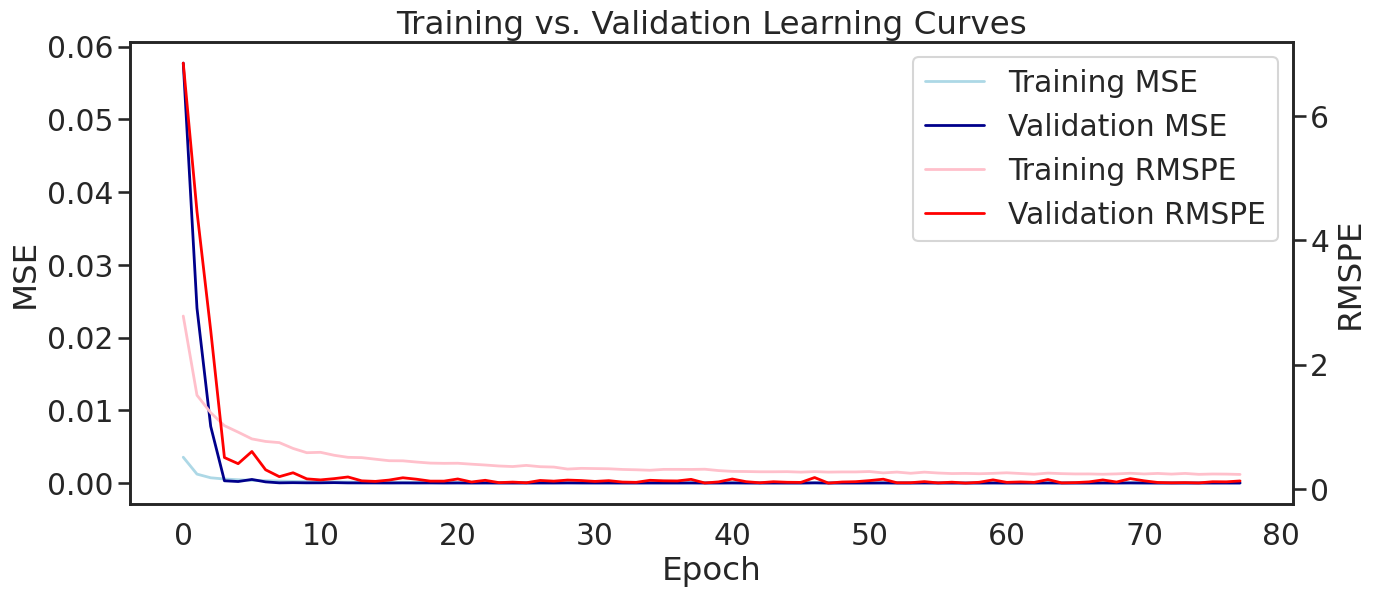

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

12/12 [==============================] - 3s 21ms/step


Đường dự báo đã di chuyển ngang hơn đến các đường mục tiêu, và thực tế đã theo dõi đầu ra mong muốn rất gần giữa tháng 11 năm 2020 đến tháng 2 năm 2021. Điều này chắc chắn là một cải tiến so với tất cả các mô hình trước đó. Nó cũng không có vẻ ồn ào như một số mô hình khác.

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061
4,"Simple LR Fully Connected NN, n_past=14",0.617320,0.063809
5,"LSTM 1 layer 20 units, n_past=14",0.622585,0.062673
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.587727,0.059264
7,"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",0.649781,0.064653
8,"2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05",1.074338,0.088198
9,"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30",0.617614,0.052421


Đây là mô hình đầu tiên với một Validation RMSPE dưới 0.2, và thực tế gần 5% thấp hơn so với mô hình tốt nhất được tìm thấy trước đó (Univariate LSTM với 2 lớp).

(Tôi cũng đã thử nghiệm việc thêm các lớp convolutional 1D vào các mô hình LSTM Multivariate này, có sẵn trong thư mục Notebook Khám phá, nhưng không tạo ra kết quả tốt hơn, vì vậy tôi sẽ bỏ qua phiên bản đó ở đây).

**4.8. Mô hình LSTM kép ba lớp với chuỗi hai chiều (Multivariate 3-Layered Bidirectional LSTM)**

Tiếp theo, tôi sẽ thêm nhiều lớp LSTM hơn để xem liệu điều này có giúp cải thiện hiệu suất không.

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_6 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 128)           35328     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 64)            41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                        

In [ ]:
lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

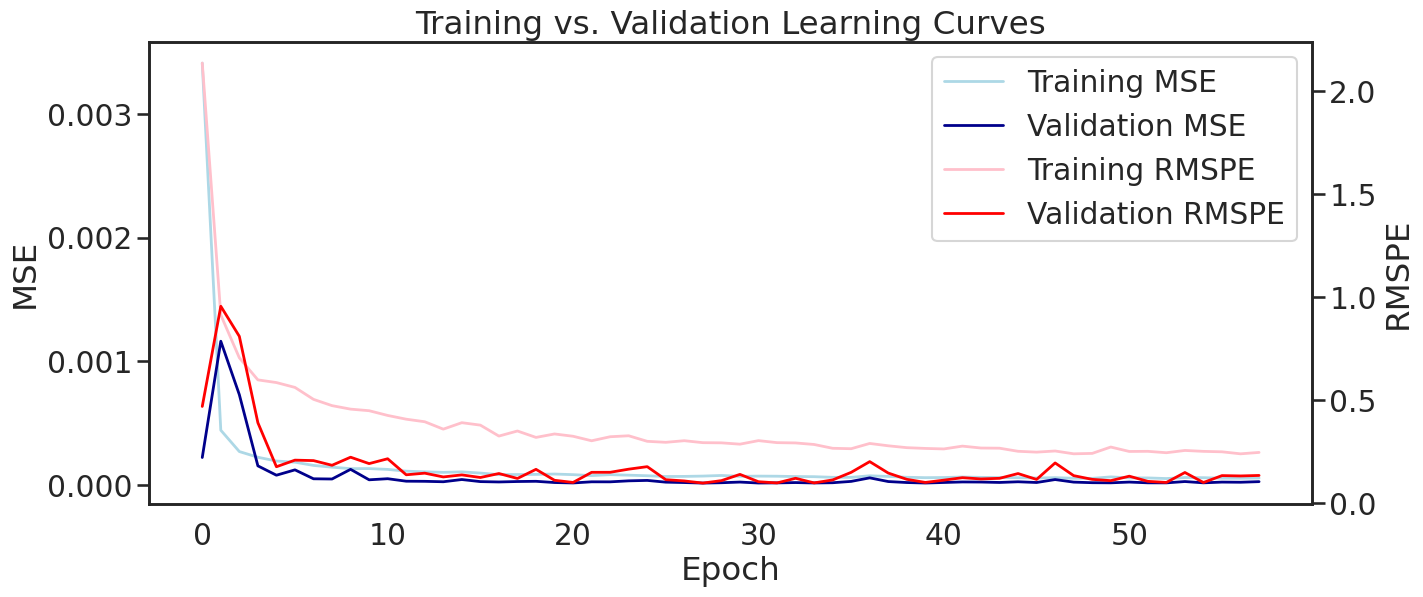

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_6_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_6_preds = forecast_multi(lstm_6, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_6_preds_scaled = scale(scaler_vol, lstm_6_preds)

12/12 [==============================] - 6s 36ms/step


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061
4,"Simple LR Fully Connected NN, n_past=14",0.617320,0.063809
5,"LSTM 1 layer 20 units, n_past=14",0.622585,0.062673
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.587727,0.059264
7,"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",0.649781,0.064653
8,"2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05",1.074338,0.088198
9,"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30",0.617614,0.052421


Thêm một lớp LSTM đã giúp giảm RMSE một chút (từ 0.046139 xuống còn 0.044660), nhưng RMSPE thực tế đã tăng một chút (từ 0.156677 lên còn 0.164623).

**4.9. Multivariate 4-Layered Bidirectional LSTM**

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_7 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 4th LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_7.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_7.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 256)           136192    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 128)           164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                        

In [ ]:
# FITTING TO TRAINING DATA
lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

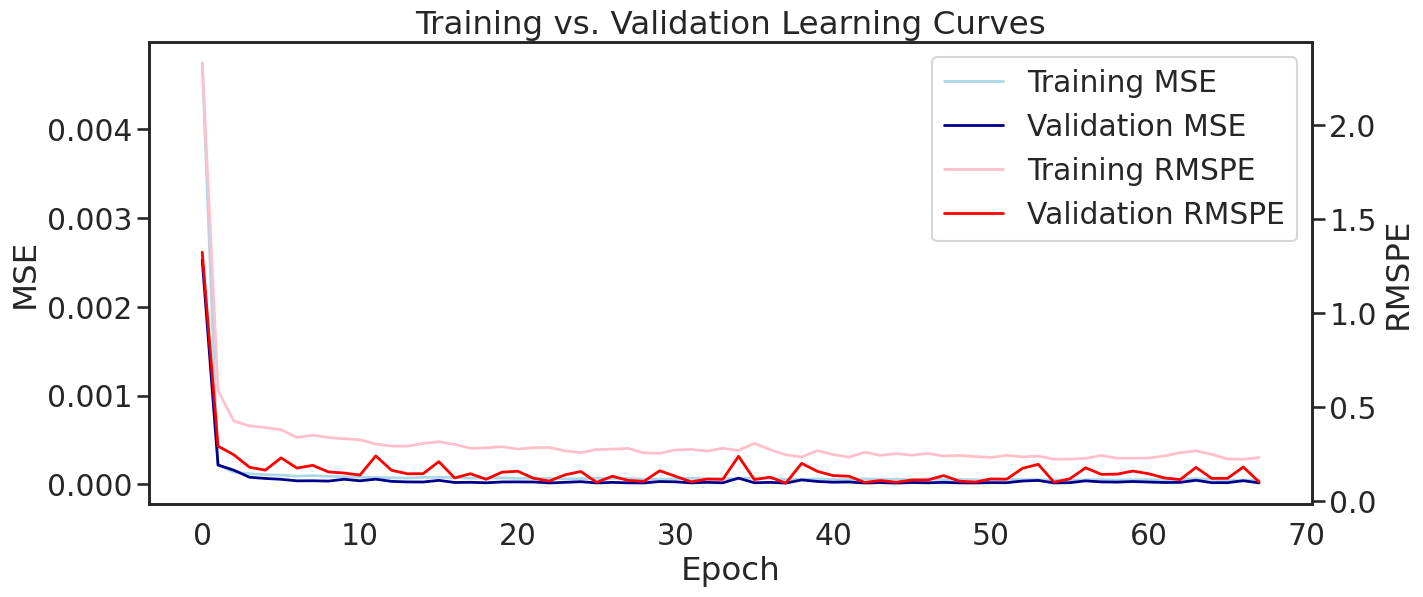

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_7_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_7_preds = forecast_multi(lstm_7, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_7_preds_scaled = scale(scaler_vol, lstm_7_preds)

12/12 [==============================] - 4s 51ms/step


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_7_preds_scaled,
         f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061
4,"Simple LR Fully Connected NN, n_past=14",0.617320,0.063809
5,"LSTM 1 layer 20 units, n_past=14",0.622585,0.062673
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.587727,0.059264
7,"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",0.649781,0.064653
8,"2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05",1.074338,0.088198
9,"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30",0.617614,0.052421


Có vẻ như sau 3 lớp, validation RMSPE bắt đầu tăng lên.

#**LSTM Network Tuning**

Trong phần này, tôi sẽ sử dụng thư viện talos để tìm kiếm các sự kết hợp khác nhau cho việc tinh chỉnh siêu tham số chỉ để đảm bảo rằng tôi không bỏ sót bất kỳ điều gì tiềm năng nào.

In [ ]:
from statsmodels.compat.pandas import Appender

In [ ]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
pip install talos

  Using cached talos-1.3-py3-none-any.whl (56 kB)
  Using cached wrangle-0.7.2-py3-none-any.whl (52 kB)
  Using cached astetik-1.13-py3-none-any.whl (5.4 MB)
  Using cached sklearn-0.0.post10.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for geonamescache from https://files.pythonhosted.org/packages/2e/8a/6555e3c3ed1fcadf229dcfb41b92d51eb0c7623d42290e1d6925ac383b33/geonamescache-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for jedi>=0.16 from https://files.pythonhosted.org/packages/20/9f/bc63f0f0737ad7a60800bfd472a4836661adae21f9c2535f3957b1e54ceb/jedi-0.19.1-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.8 MB/s eta 0:00:00
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41593 sha256=db452f4669af06a31958fbda99f726812ea7e665bb582553cbe9

In [ ]:
import talos

In [ ]:
def lstm_network(X_tr, y_tr, X_v, y_v, params):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]))

    # HIDDEN LAYERS
    for layer in range(params['lstm_layers'],1,-1):
        # FOR THE LAST LAYER - return_sequences NEEDS TO BE False
        # ALL OTHER LAYERS - returns_sequences = True
        seq = False if layer == 1 else True

        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2**(layer+3),
                                                                     return_sequences=seq,
                                                                     activation=params['activation'])))
        model.add(tf.keras.layers.Dropout(params['dropout']))

    model.add(tf.keras.layers.Dense(1))

    # COMPILE
    model.compile(loss='mse',
                  optimizer='adam',
                  metrics=[rmspe])

    # STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
    early_stopping_cb = EarlyStopping(patience=3,
                                      restore_best_weights=True,
                                      monitor='val_rmspe')
    # FIT
    res = model.fit(X_tr, y_tr,
                    validation_data=(X_v, y_v),
                    batch_size=params['batch_size'],
                    epochs=10,
                    verbose=0,
                    callbacks=[early_stopping_cb])

    return res, model

In [ ]:
params = {'dropout': [0.1, 0.2],
          'activation': ['relu', 'tanh', 'sigmoid'],
          'lstm_layers': [2,3,4],
          'batch_size': [32,64]}

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

from_i = val_idx[0] - timedelta(n_past - 1)
to_i = val_idx[-1]
mat_X_val, mat_y_val = windowed_dataset(input_df[from_i:to_i],
                                        df.vol_future[val_idx], n_past)

results = talos.Scan(x=mat_X_train, y=mat_y_train,
                     x_val=mat_X_val, y_val=mat_y_val,
                     params=params,
                     model=lstm_network,
                     experiment_name='grid',
                     reduction_metric='rmspe',
                     minimize_loss=True)

100%|██████████| 36/36 [46:12<00:00, 77.00s/it]


In [ ]:
results.data.sort_values(by='val_rmspe', ascending=True)[:3]

,start,end,duration,round_epochs,loss,rmspe,val_loss,val_rmspe,dropout,activation,lstm_layers,batch_size
3,10/15/23-055539,10/15/23-055620,40.953855,7,0.000360,0.770772,0.000084,0.476353,0.1,relu,3,64
20,10/15/23-061826,10/15/23-061922,55.634228,7,0.000548,0.881104,0.000129,0.579576,0.2,relu,3,32
2,10/15/23-055447,10/15/23-055535,47.145137,6,0.000331,0.753574,0.000130,0.593671,0.1,relu,3,32


In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 32
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_8 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,
                                                       activation='tanh')),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='tanh')),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_8.compile(loss='mse',
               optimizer="adam",
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_8.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_8.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 64)            9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
# FITTING TO TRAINING DATA
lstm_8_res = lstm_8.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

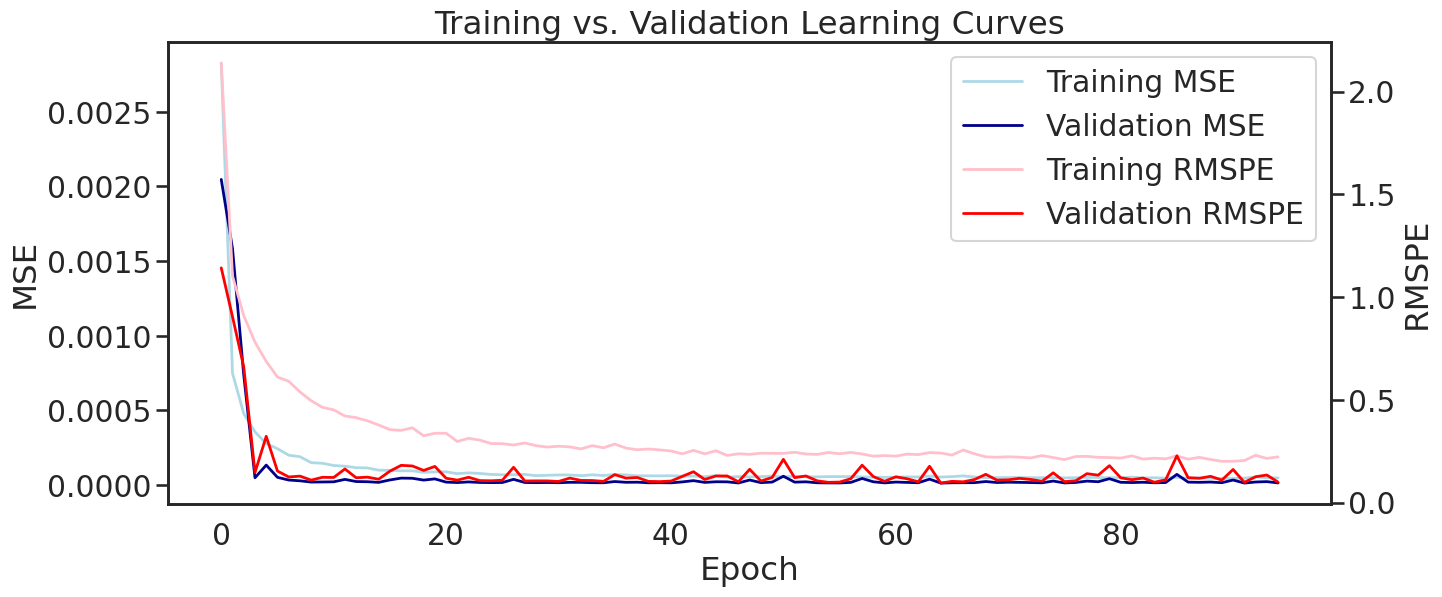

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_8_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_8_preds = forecast_multi(lstm_8, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_8_preds_scaled = scale(scaler_vol, lstm_8_preds)

12/12 [==============================] - 3s 23ms/step


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_8_preds_scaled,
         f"Multivariate 2 Bidirect LSTM layers (32/16 units), n_past={n_past}, batch={batch_size}, tanh")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,2.134868,0.150878
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061
4,"Simple LR Fully Connected NN, n_past=14",0.617320,0.063809
5,"LSTM 1 layer 20 units, n_past=14",0.622585,0.062673
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.587727,0.059264
7,"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",0.649781,0.064653
8,"2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05",1.074338,0.088198
9,"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30",0.617614,0.052421


# **Final Model**

In [ ]:
perf_df.sort_values(by='Validation RMSPE', ascending=True)

,Model,Validation RMSPE,Validation RMSE
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.317118,0.061061
12,"Multivariate 2 Bidirect LSTM layers (32/16 units), n_past=30, batch=32, tanh",0.483512,0.047676
1,Random Walk Naive Forecasting,0.505790,0.063288
2,"GARCH(1,1), Constant Mean, Normal Dist",0.506895,0.106906
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.587727,0.059264
10,"Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30",0.597560,0.052200
4,"Simple LR Fully Connected NN, n_past=14",0.617320,0.063809
9,"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30",0.617614,0.052421
5,"LSTM 1 layer 20 units, n_past=14",0.622585,0.062673
11,"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past=30, batch=64",0.626104,0.052768


Đối với mô hình cuối cùng này, tôi sẽ tạo lại cùng một kiến trúc như mô hình #12 (Multivariate Bidirectional LSTM với 2 lớp 32/16 đơn vị) và một cửa sổ quan sát n_past = 30 và kích thước batch = 64. Tuy nhiên, tôi sẽ mở rộng việc huấn luyện để bao gồm cả tập validation. Điều này quan trọng trong dữ liệu chuỗi thời gian vì các bước thời gian gần đây có khả năng chứa thông tin quan trọng hơn cho dự báo thành công so với dữ liệu từ một năm trước.

Vì các đường MSE và RMSPE trên tập validation đã rất không ổn định, tôi sẽ mở rộng số epoch huấn luyện lên 500 để xem liệu điều này có thể giúp ghi nhận được các trọng số tốt hơn hay không.

In [ ]:
# CREATE DATASET THAT COMBINES BOTH TRAINING & VALIDATION
tv_df = input_df[:split_time_2]
tv_y = df.vol_future[:split_time_2]

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse',
                    optimizer="adam",
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_final.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 64)            9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

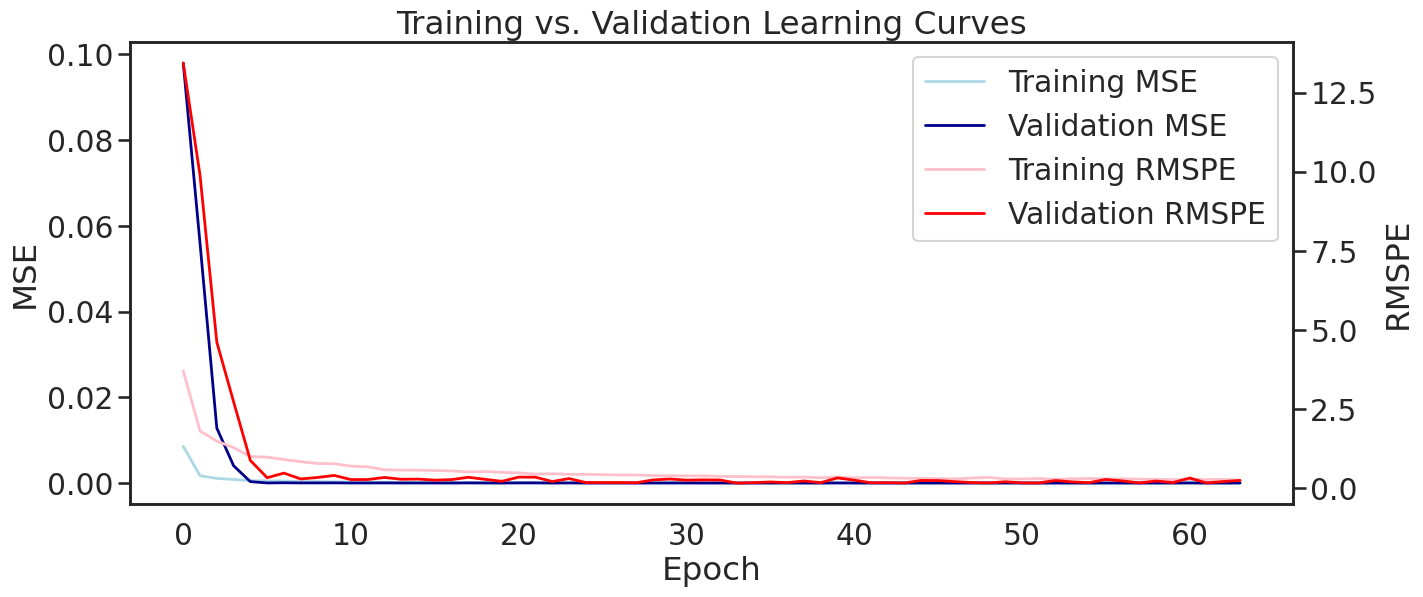

In [ ]:
viz_train_val_metrics(lstm_final_res)

**Final Model's Predictions on Test Set**

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_final_preds = forecast_multi(lstm_final, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_final_preds_scaled = scale(scaler_vol, lstm_final_preds)

12/12 [==============================] - 0s 20ms/step


In [6]:
log_perf(y_val_scaled, lstm_final_preds_scaled,
         f"Multivariate 2 Bidirect LSTM layers (32/16 units,epoch=500), n_past={n_past}, batch={batch_size}, tanh")

NameError: ignored

In [5]:
perf_df.sort_values(by='Validation RMSPE', ascending=True)

NameError: ignored

In [ ]:
# FORECASTING ON VALIDATION SET
y_test_preds = forecast_multi(lstm_final, test_idx)

1/1 [==============================] - 3s 3s/step


In [ ]:
y_test_preds.describe()

count    30.000000
mean      0.019736
std       0.002071
min       0.014888
25%       0.018908
50%       0.019980
75%       0.021199
max       0.023380
dtype: float64

In [ ]:
y_test.describe()

count    30.000000
mean      0.020164
std       0.002333
min       0.015135
25%       0.018404
50%       0.021784
75%       0.021856
max       0.023119
Name: vol_future, dtype: float64

In [ ]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

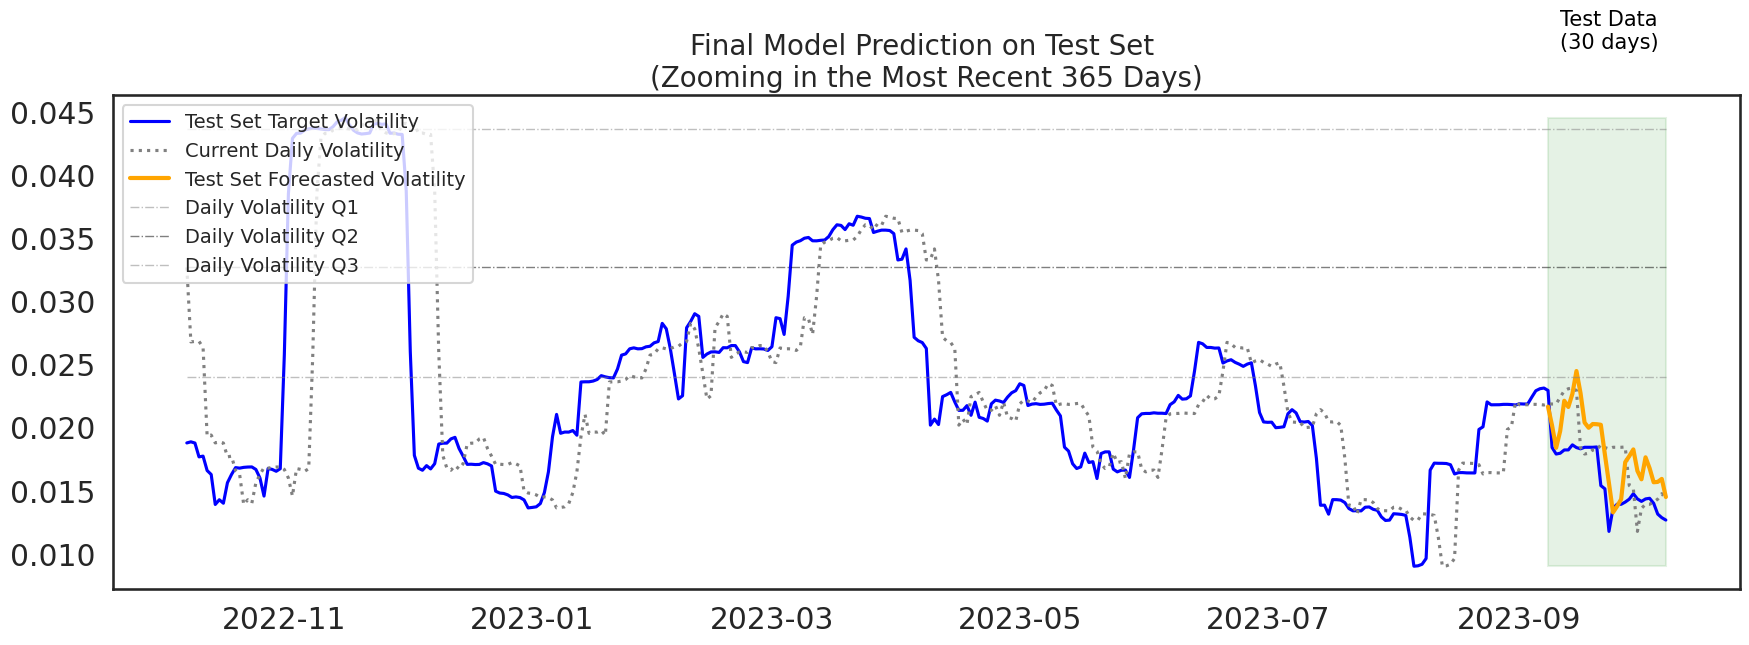

In [ ]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib

# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue',
                label=f"Test Set Target Volatility")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls=':',
                label=f"Current Daily Volatility")
    ax1.plot(y_test_preds, color='orange', lw=3,
                label=f'Test Set Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q, color=q_colors[i], alpha=0.5, label=f'Daily Volatility Q{i+1}', ls='-.', lw=1,
                    xmin=df.vol_future[-n_display:].index[0],
                    xmax=df.vol_future[-n_display:].index[-1])

    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA
    w = len(test_idx) - 1
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05,
             'Test Data\n(30 days)',
             fontsize=15, color='black')

    plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_test_preds.png'),
                dpi=300, bbox_inches='tight')
    plt.show();

In [ ]:
# GENERATING PREDICTIONS ON THE WHOLE DATASET (7 years)
mat_X_all, _ = windowed_dataset(input_df, df.vol_future, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all)[:,0],
                      index=df.index[-(mat_X_all).shape[0]:])

99/99 [==============================] - 1s 12ms/step


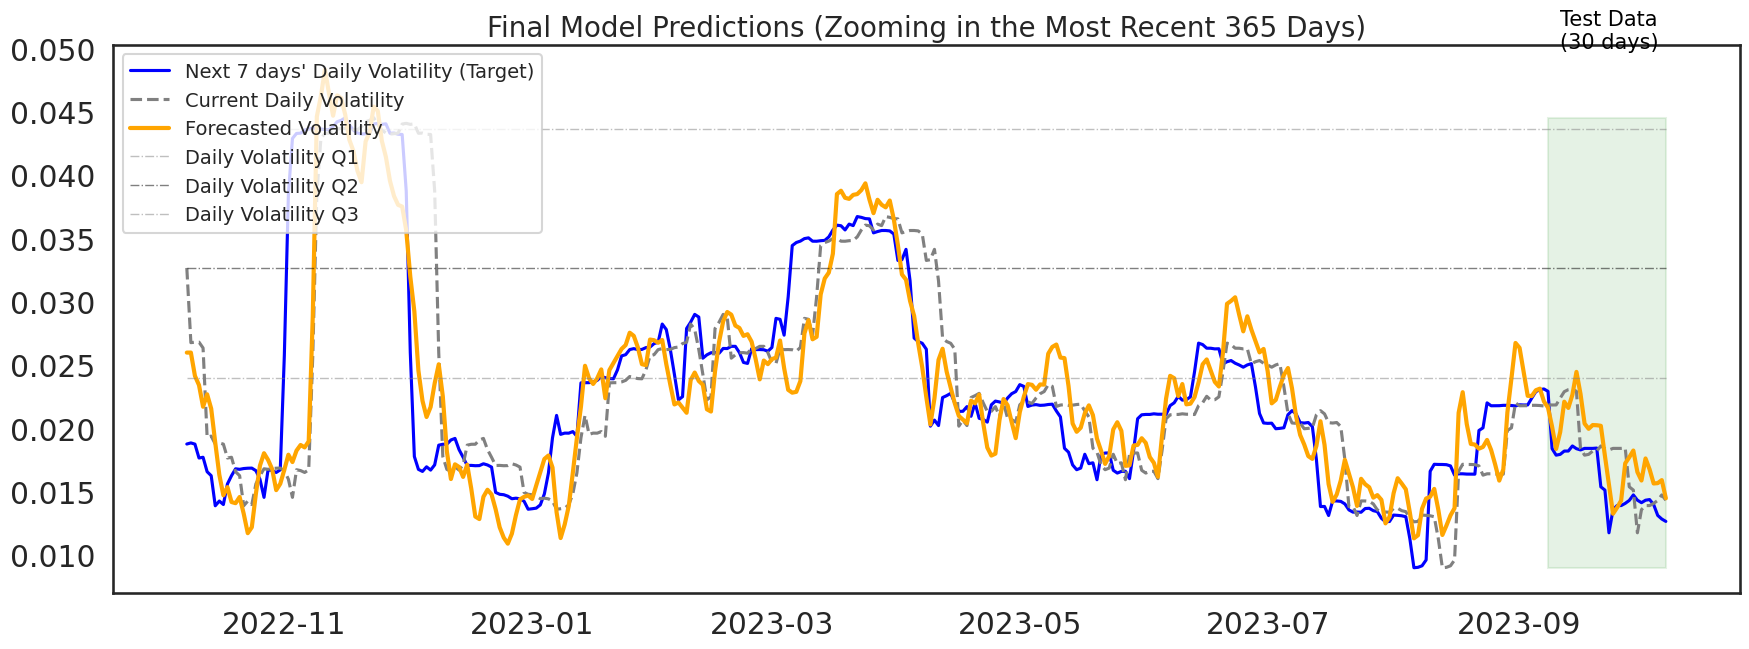

In [ ]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue',
                label=f"Next {n_future} days' Daily Volatility (Target)")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
                label=f"Current Daily Volatility")
    ax1.plot(preds_all[-n_display:], color='orange', lw=3,
                label=f'Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q,
                   xmin=df.vol_future[-n_display:].index[0],
                   xmax=df.vol_future[-n_display:].index[-1],
                   label=f'Daily Volatility Q{i+1}',
                   ls='-.', lw=1, color=q_colors[i], alpha=0.5)

    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA
    w = len(test_idx) - 1
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05,
             'Test Data\n(30 days)',
             fontsize=15, color='black')

    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_preds.png'),
                dpi=300, bbox_inches='tight')
    plt.show();

Cần nhấn mạnh rằng mô hình đã được huấn luyện trên cả dữ liệu huấn luyện và validation lần này. Do đó, nó sẽ tự nhiên mô phỏng mục tiêu gần hơn cho đến tuần thứ ba của tháng 7 năm 2021 khi tập validation kết thúc.

In [ ]:
perf_df.to_pickle("performance_df.pkl")

In [ ]:
print('RMSPE on Test Set:', RMSPE(y_test, y_test_preds))

RMSPE on Test Set: 0.18296619200179828


In [ ]:
1-RMSPE(y_test, y_test_preds)

0.8170338079982017

# **Kết luận**

Về hiệu suất trên tập validation (từ 23/07/2020 đến 25/07/2021), mô hình LSTM cuối cùng của tôi có một RMSPE là 0.156677, tương đương với khoảng 4.42% tốt hơn so với các biến thể tốt nhất của các mô hình GARCH - TARCH(1,2) với RMSPE là 0.200954. Các nhà giao dịch không cần phải đưa ra dự báo hoàn hảo để có kỳ vọng tích cực khi tham gia vào thị trường, họ chỉ cần đưa ra dự báo chính xác và chính xác hơn so với sự đồng thuận chung. Với GARCH vẫn là mô hình dự báo biến động phổ biến nhất, LSTM đa biến có thể tiềm năng mang lại lợi thế về độ chính xác dự báo cao hơn.

Mô hình LSTM cuối cùng có một RMSPE là 0.0534 trên tập kiểm tra (đó là 30 ngày gần đây nhất mà dữ liệu biến động tương lai có sẵn để so sánh). Khi RMSPE cho biết sự dao động trung bình của sai số so với các giá trị thực tế, một RMSPE là 0.0534 sẽ tương đương với một độ chính xác dao động trung bình là 94.65% đối với việc dự báo biến động hàng ngày trung bình trên chu kỳ 7 ngày trong khoảng từ 24/07/2021 đến 22/08/2021.

Tuy nhiên, do dữ liệu chuỗi thời gian tài chính luôn thay đổi, không có mô hình nào có thể dự báo một cách liên tục với mức độ chính xác cao mãi mãi. Tuổi thọ trung bình của một mô hình nằm trong khoảng từ 6 tháng đến 5 năm, và có một hiện tượng trong giao dịch lượng tử được gọi là sự giảm giá alpha, đó là sự mất mát trong khả năng dự báo của một mô hình alpha theo thời gian. Ngoài ra, theo Sinclair (2020), các nhà nghiên cứu đã phát hiện ra rằng việc công bố một "đỉnh" hoặc biến thể mới trên thị trường giảm lợi nhuận của nó lên đến 58%.

Do đó, các mô hình này yêu cầu việc điều chỉnh và điều chỉnh liên tục dựa trên thông tin mới nhất có sẵn để đảm bảo rằng chúng luôn cập nhật và học cách tiến triển cùng với thị trường.

# **Bước Tiếp Theo**

Như đã đề cập ngắn gọn ở trên, tôi nghĩ rằng có tiềm năng ứng dụng của WaveNet trong việc dự báo biến động, và muốn khám phá tùy chọn đó trong tương lai.

Ngoài ra, mọi người đều biết rằng các sự kiện kinh tế có thể ảnh hưởng đến động lực của thị trường. Vì tiền điện tử có một số đặc điểm khác biệt so với các cổ phiếu và hàng hóa khác, việc tích hợp các sự kiện trên lịch kinh tế thông thường có thể không phải là phù hợp nhất. Hiện tại, tôi vẫn đang tiến hành nghiên cứu thêm về việc thu thập các sự kiện quan trọng có thể đã thúc đẩy sự di chuyển của Bitcoin, và muốn tích hợp chúng vào một bộ mô hình LSTM đa biến khác trong tương lai để hy vọng cải thiện khả năng dự báo hơn nữa.

Cuối cùng, tôi muốn thử nghiệm với tần suất cao hơn (ví dụ: trong ngày), cũng như các khoảng thời gian chia khác.

**References:**

Géron, A. (2019). In Hands-on machine learning with Scikit-Learn & TensorFlow: concepts, tools, and techniques to build intelligent systems. O'Reilly Media, Inc.

Sinclair, E. (2020). Positional option trading: An advanced guide. John Wiley & Sons.

https://algotrading101.com/learn/yfinance-guide/

https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

https://insights.deribit.com/options-course/

https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html

https://www.investopedia.com/terms/v/vix.asp

https://www.hindawi.com/journals/complexity/2021/6647534/

https://github.com/ritvikmath/Time-Series-Analysis/blob/master/GARCH%20Stock%20Modeling.ipynb

https://github.com/ritvikmath/Time-Series-Analysis/blob/master/GARCH%20Model.ipynb

https://www.kaggle.com/c/optiver-realized-volatility-prediction

https://www.youtube.com/watch?v=NKHQiN-08S8

https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/

https://towardsdatascience.com/time-series-analysis-on-multivariate-data-in-tensorflow-2f0591088502

https://deepmind.com/blog/article/wavenet-generative-model-raw-audio

https://github.com/philipperemy/keras-tcn

http://users.metu.edu.tr/ozancan/ARCHGARCHTutorial.html

https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95